# Market Analysis

In this exercise, we investigate the performance of delivery platform, which is newly launced in New York City. The primary objective here is to track the Key Performance indicators(KPI's) throughout the entire timeline presented in this dataset.

## Import Data and Required Libraries

In [1]:
#import Data Manipulation packages

import pandas as pd
import numpy as np
import warnings
import math
warnings.filterwarnings("ignore")
import itertools
from itertools import groupby
import re
import string
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

# import visualization packages

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime as dt
%config InlineBackend.figure_format ='retina'
plt.style.use('seaborn-white')

# import geographical data pacakges

import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon

ModuleNotFoundError: No module named 'geopandas'

In [2]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', -1)

In [3]:
jumpman_data = pd.read_csv('analyze_me.csv')
jumpman_data.head(3)

,delivery_id,customer_id,jumpman_id,vehicle_type,pickup_place,place_category,item_name,item_quantity,item_category_name,how_long_it_took_to_order,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,when_the_delivery_started,when_the_Jumpman_arrived_at_pickup,when_the_Jumpman_left_pickup,when_the_Jumpman_arrived_at_dropoff
0,1457973,327168,162381,van,Melt Shop,American,Lemonade,1.0,Beverages,00:19:58.582052,40.744607,-73.990742,40.752073,-73.985370,2014-10-26 13:51:59.898924,NaN,NaN,2014-10-26 14:52:06.313088
1,1377056,64452,104533,bicycle,Prince Street Pizza,Pizza,Neapolitan Rice Balls,3.0,Munchables,00:25:09.107093,40.723080,-73.994615,40.719722,-73.991858,2014-10-16 21:58:58.65491,2014-10-16 22:26:02.120931,2014-10-16 22:48:23.091253,2014-10-16 22:59:22.948873
2,1476547,83095,132725,bicycle,Bareburger,Burger,Bare Sodas,1.0,Drinks,00:06:44.541717,40.728478,-73.998392,40.728606,-73.995143,2014-10-28 21:39:52.654394,2014-10-28 21:37:18.793405,2014-10-28 21:59:09.98481,2014-10-28 22:04:40.634962


In [4]:
jumpman_data.shape

(5983, 18)

In [5]:
jumpman_data.columns

Index(['delivery_id', 'customer_id', 'jumpman_id', 'vehicle_type',
       'pickup_place', 'place_category', 'item_name', 'item_quantity',
       'item_category_name', 'how_long_it_took_to_order', 'pickup_lat',
       'pickup_lon', 'dropoff_lat', 'dropoff_lon', 'when_the_delivery_started',
       'when_the_Jumpman_arrived_at_pickup', 'when_the_Jumpman_left_pickup',
       'when_the_Jumpman_arrived_at_dropoff'],
      dtype='object')

In [6]:
jumpman_data.dtypes

delivery_id                            int64  
customer_id                            int64  
jumpman_id                             int64  
vehicle_type                           object 
pickup_place                           object 
place_category                         object 
item_name                              object 
item_quantity                          float64
item_category_name                     object 
how_long_it_took_to_order              object 
pickup_lat                             float64
pickup_lon                             float64
dropoff_lat                            float64
dropoff_lon                            float64
when_the_delivery_started              object 
when_the_Jumpman_arrived_at_pickup     object 
when_the_Jumpman_left_pickup           object 
when_the_Jumpman_arrived_at_dropoff    object 
dtype: object

## Data Preprocessing


### Columns with Missing values
As a measure of data completion, we'll identify the columns with missing values.  

In [7]:
col_names = ['column_name', 'missing_pct']
df_missing = pd.DataFrame(columns=col_names)
#cnt=0
for i in jumpman_data.columns:
    x = sum(pd.isna(jumpman_data[i]))

    l = list((i, round((x / jumpman_data.shape[0]) * 100, 2)))
    df_missing.loc[len(df_missing.index) + 1] = l
df_missing.sort_values(by='missing_pct', axis=0, ascending=False, inplace=True)
#cnt+=1

In [8]:
df_missing[df_missing['missing_pct'] > 0.00]

,column_name,missing_pct
10,how_long_it_took_to_order,49.22
7,item_name,20.56
8,item_quantity,20.56
9,item_category_name,20.56
6,place_category,14.76
17,when_the_Jumpman_left_pickup,9.19
16,when_the_Jumpman_arrived_at_pickup,9.19


From the above investigation, we find that the column `how_long_it_took_to_order` has significant amount of missing data. This can be a shortcoming to the conclusion derived from the analysis. We will address this issue in the section on Handling Missing Values.

### Feature Extraction Using Datetime Information
Since the data is about delivery service, it is quite crucial to use the time information. Customers highly prefer those delivery services that are quite prompt.

In [9]:
jumpman_data['dropoff_time'] = jumpman_data[
    'when_the_Jumpman_arrived_at_dropoff'].apply(lambda x: pd.to_datetime(x))
jumpman_data['pickup_arrival']=jumpman_data['when_the_Jumpman_arrived_at_pickup'].\
                                    apply(lambda x: pd.to_datetime(x) if pd.notnull(x) else x)
jumpman_data['pickup_depart']=jumpman_data['when_the_Jumpman_left_pickup'].\
                                    apply(lambda x: pd.to_datetime(x) if pd.notnull(x) else x)
jumpman_data['delivery_start']=jumpman_data['when_the_delivery_started'].\
                                    apply(lambda x: pd.to_datetime(x) if pd.notnull(x) else x)

jumpman_data['weekday'] = jumpman_data['dropoff_time'].dt.day_name()
jumpman_data['month'] = jumpman_data['dropoff_time'].dt.month
jumpman_data['hour'] = jumpman_data['dropoff_time'].dt.hour
jumpman_data['date'] = jumpman_data['dropoff_time'].dt.date
jumpman_data['year'] = jumpman_data['dropoff_time'].dt.year
jumpman_data['day'] = jumpman_data['dropoff_time'].dt.day
jumpman_data['Day_Duration']= jumpman_data['hour'].\
                             apply(lambda x: 'Morning' \
                            if (x < 12 and x > 3)\
                            else('Noon' if (x>12 and x<16) \
                            else('Evening' if (x>16 and x<20)\
                            else 'Night')))

#Next we will define variables to calculate time spent in delivery or food preparation

jumpman_data['food_prep_time'] = (
    jumpman_data['pickup_depart'] -
    jumpman_data['pickup_arrival']).astype('timedelta64[m]')
jumpman_data['weekend'] = jumpman_data['weekday'].apply(
    lambda x: 'Yes' if x in ('Sunday', 'Saturday') else 'No')
jumpman_data['total_time'] = (
    jumpman_data['dropoff_time'] -
    jumpman_data['delivery_start']).astype('timedelta64[m]')

In [10]:
jumpman_data.head(3)

,delivery_id,customer_id,jumpman_id,vehicle_type,pickup_place,place_category,item_name,item_quantity,item_category_name,how_long_it_took_to_order,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,when_the_delivery_started,when_the_Jumpman_arrived_at_pickup,when_the_Jumpman_left_pickup,when_the_Jumpman_arrived_at_dropoff,dropoff_time,pickup_arrival,pickup_depart,delivery_start,weekday,month,hour,date,year,day,Day_Duration,food_prep_time,weekend,total_time
0,1457973,327168,162381,van,Melt Shop,American,Lemonade,1.0,Beverages,00:19:58.582052,40.744607,-73.990742,40.752073,-73.985370,2014-10-26 13:51:59.898924,NaN,NaN,2014-10-26 14:52:06.313088,2014-10-26 14:52:06.313088,NaT,NaT,2014-10-26 13:51:59.898924,Sunday,10,14,2014-10-26,2014,26,Noon,NaN,Yes,60.0
1,1377056,64452,104533,bicycle,Prince Street Pizza,Pizza,Neapolitan Rice Balls,3.0,Munchables,00:25:09.107093,40.723080,-73.994615,40.719722,-73.991858,2014-10-16 21:58:58.65491,2014-10-16 22:26:02.120931,2014-10-16 22:48:23.091253,2014-10-16 22:59:22.948873,2014-10-16 22:59:22.948873,2014-10-16 22:26:02.120931,2014-10-16 22:48:23.091253,2014-10-16 21:58:58.654910,Thursday,10,22,2014-10-16,2014,16,Night,22.0,No,60.0
2,1476547,83095,132725,bicycle,Bareburger,Burger,Bare Sodas,1.0,Drinks,00:06:44.541717,40.728478,-73.998392,40.728606,-73.995143,2014-10-28 21:39:52.654394,2014-10-28 21:37:18.793405,2014-10-28 21:59:09.98481,2014-10-28 22:04:40.634962,2014-10-28 22:04:40.634962,2014-10-28 21:37:18.793405,2014-10-28 21:59:09.984810,2014-10-28 21:39:52.654394,Tuesday,10,22,2014-10-28,2014,28,Night,21.0,No,24.0


In [11]:
#drop off the unncessary columns, since useful information has been extracted from it.
jumpman_data.drop(
    ['when_the_Jumpman_arrived_at_dropoff', 'when_the_delivery_started'],
    axis=1,
    inplace=True)

## Exploratory Analysis

### Exploring Key Performance Indicators

First as data exploration, it will be interesting to see whether the customers using this sevice or not. We are going to follow a Top-down appoach, i.e. we will look at overall trend of KPI's first and then dig into details regarding location and item categories.  We will look at some basic KPI's; namely,

* Weekly comparison of Average Daily Performance
* Average Item count per Delivery
* Average number of deliveries made per hour on a given day
* Average Order Duration
* Food Preparation time
* Delivery time

#### Weekly Comparison of Average Daily Performance


Since entire dataset is covering the month of October in the year 2014, it makes sense to either look at weekly performance or daily performance. Daily performance might be quite noisy, hence it will be better to look at weekly behavior. One possible way is to compare average number of daily orders across different weeks in the month of October. To be consistent, we will look at only completed orders, i.e. drop-off column is populated.

In [12]:
#bins = pd.IntervalIndex.from_tuples([(1, 8), (8, 15), (15, 22),(22,30)],closed='left')
jumpman_data['weeks']=jumpman_data['day'].\
                      apply(lambda x: 'Week1'\
                           if (1<=x<=7)\
                           else ('Week2' if (8<=x<=14)\
                           else('Week3' if (15<=x<=21)\
                           else 'Week4')))
jumpman_data.head(4)

In [13]:
weekly_count = pysqldf('''SELECT weeks, COUNT(*) AS order_cnt, COUNT(*)/7 \
                      AS daily_avg FROM jumpman_data GROUP BY weeks;''')
weekly_count

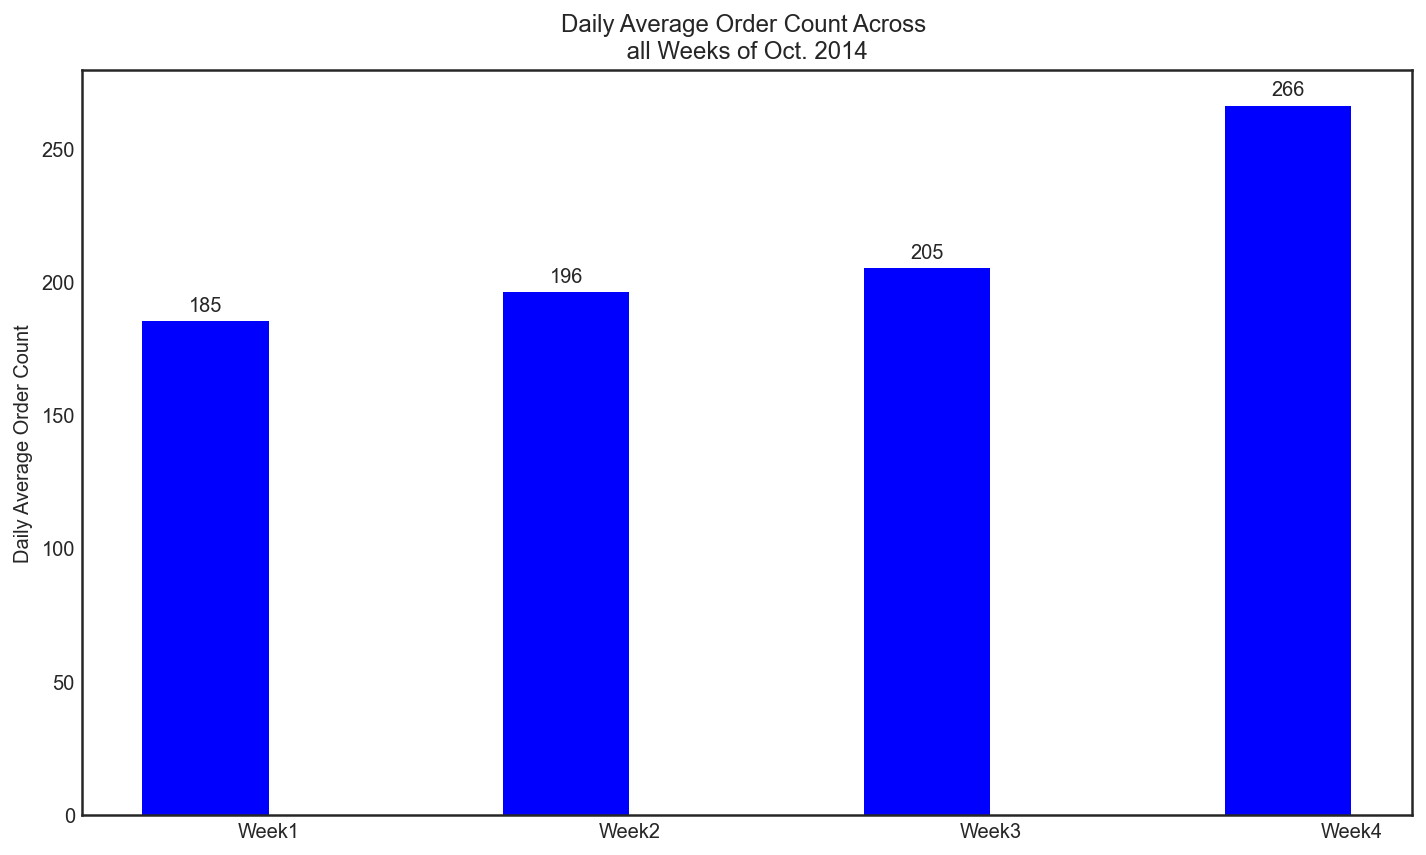

In [14]:
labels = weekly_count['weeks']
daily_avg = weekly_count['daily_avg']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width / 2, daily_avg, width, color='blue')
#rects2 = ax.bar(x + width/2, women_means, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Daily Average Order Count')
ax.set_title('Daily Average Order Count Across \n all Weeks of Oct. 2014 ')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            '{}'.format(height),
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha='center',
            va='bottom')


autolabel(rects1)
#autolabel(rects2)

fig.tight_layout()

plt.show()

Above plot suggests that the jumpman service is being increasingly used as time is passing by, thats a good sign for the business. 

#### Average Item Count Per Delivery

Another way to ascertain the popularity of the service is, are the customers ordering more items per delivery as they tend to reuse the service. To get first insight, we will look at the distribution of number of items per delivery, and look at the skewness, if any. Earlier we saw that the column `item_quantity` has almost 20 percent missing data, we will impute it with the median value and look at the distribution. Median is a suitable choice as compared to mean, since mean is not resistant to outliers.



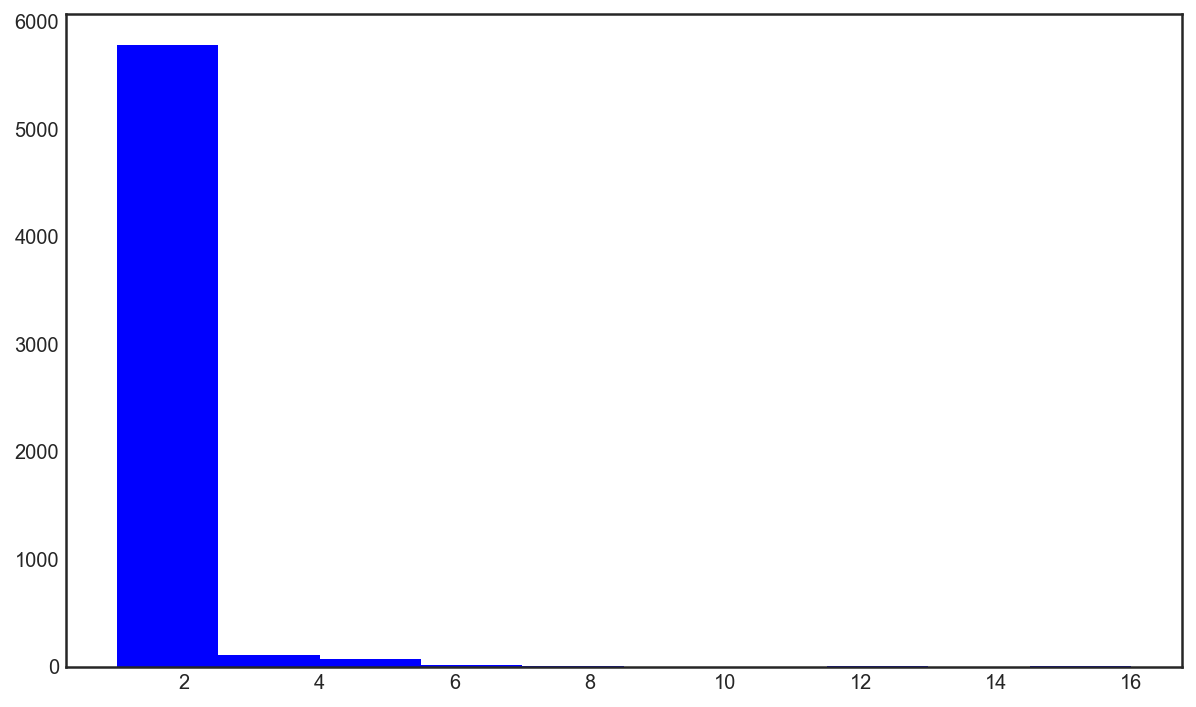

In [15]:
x = jumpman_data['item_quantity'].dropna().median()
fig, ax = plt.subplots(figsize=(10, 6))

plt.hist(jumpman_data['item_quantity'].replace(np.nan, x), color='blue')
plt.show()

The distribution for item quantity is heavily right skewed as expected. This means that number of deliveries with more than 2 items is significantly small. Next, as we discussed in the above paragraph, we impute the missing values by median, and look at the average item count per delivery on a daily basis. A line chart will be useful for this purpose.

In [16]:
jumpman_data['item_quantity'].replace(np.nan, x, inplace=True)

In [17]:
gb = jumpman_data.groupby('day')
dfx = gb.agg({
    'delivery_id': np.count_nonzero,
    'item_quantity': np.sum
}).reset_index()
dfx

In [18]:
dfx.rename(columns={
    'item_quantity': 'Total_count',
    'delivery_id': 'delivery_cnt'
},
           inplace=True)
dfx['cnt_per_delivery'] = round(dfx['Total_count'] / dfx['delivery_cnt'], 2)
dfx.head(4)

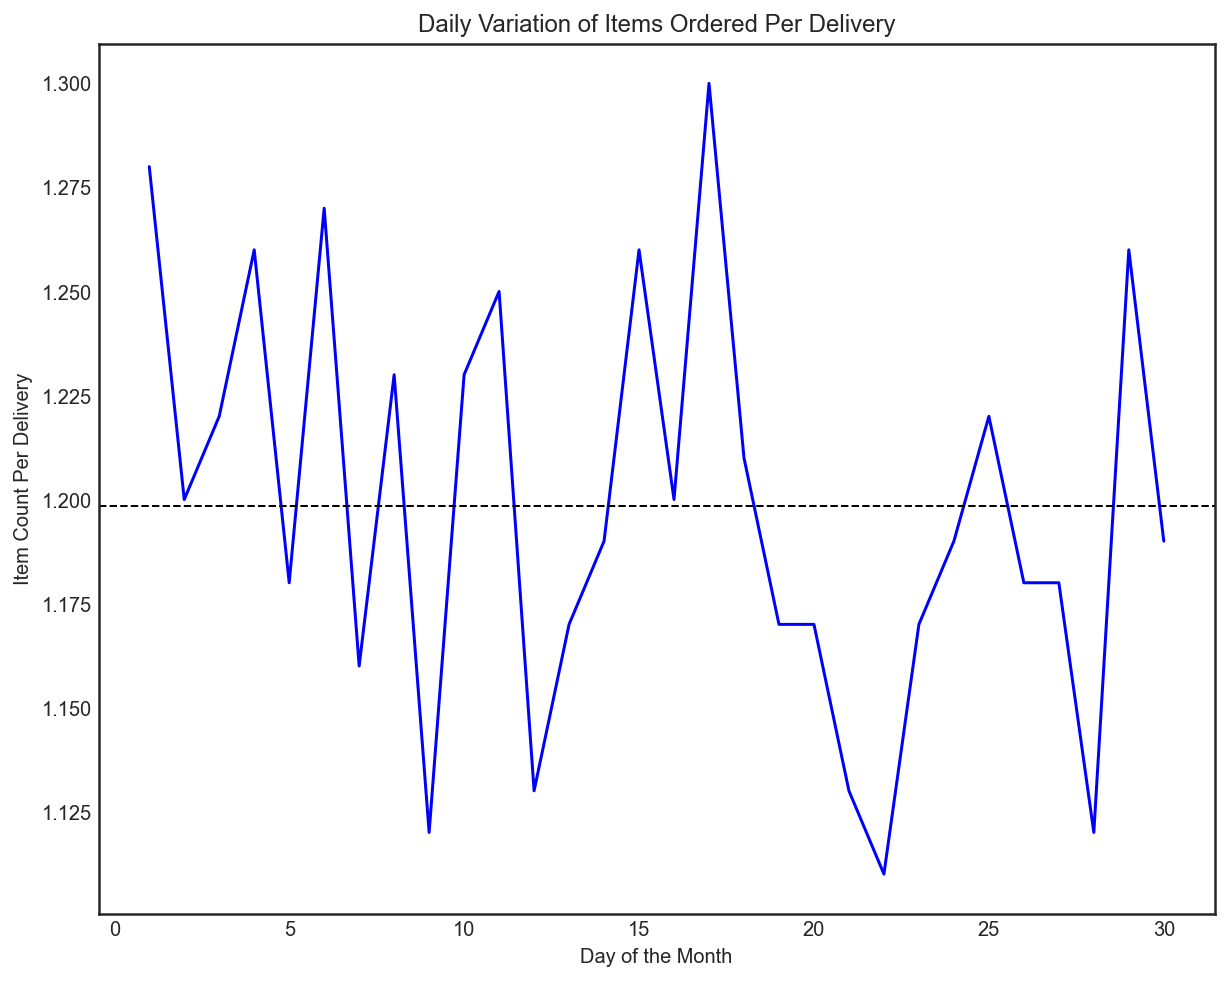

In [19]:
fig, ax = plt.subplots(figsize=(10, 8))  # Create a figure and an axes.
ax.plot(dfx['day'], dfx['cnt_per_delivery'], color='blue')
plt.axhline(dfx['cnt_per_delivery'].mean(),
            color='k',
            linestyle='dashed',
            linewidth=1)
plt.title("Daily Variation of Items Ordered Per Delivery")
plt.xlabel("Day of the Month")
plt.ylabel("Item Count Per Delivery")
plt.show()

Above line plot shows that on an average, 1.2 items are ordered per delivery throughout the month. We are not seeing any noticeable trend with time. 

#### Average Delivery Count in an Hour

Another interesting KPI to look at is average number of deliveries made per hour. This KPI is interesting in the sense that a trend in this KPI can tell ius whther the app has reached enough popularity.




In [12]:
gb_day = jumpman_data.groupby(['day', 'weekday'])
#gb_day = jumpman_data.groupby(['day'])
daily_cnt = gb_day.agg({'delivery_id': np.count_nonzero}).reset_index()
daily_cnt.rename(columns={'delivery_id': 'Total_count'}, inplace=True)
daily_cnt['delivery_per_hour'] = round(daily_cnt['Total_count'] / 24, 2)

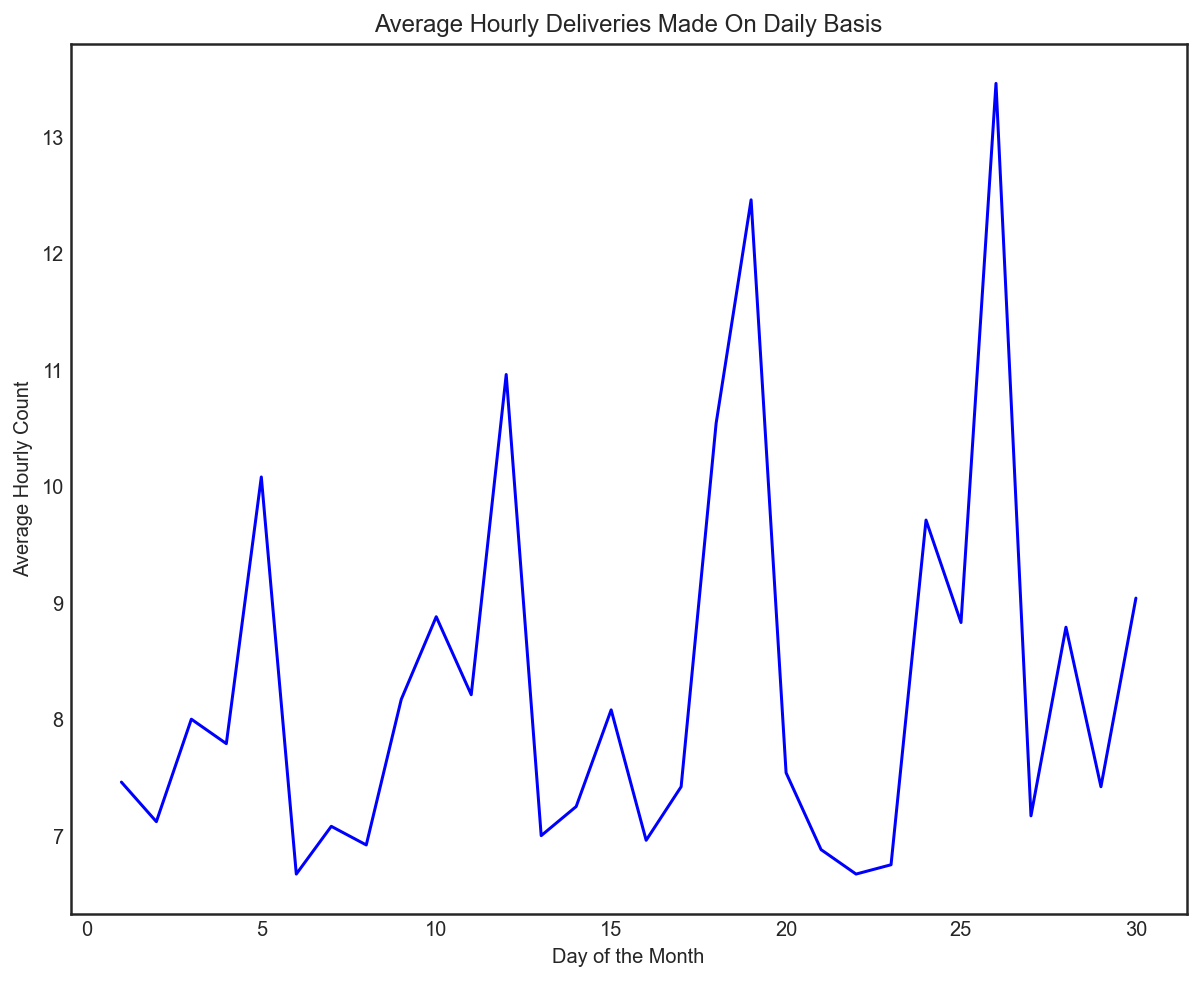

In [13]:
fig, ax = plt.subplots(figsize=(10, 8))  # Create a figure and an axes.
ax.plot(daily_cnt['day'], daily_cnt['delivery_per_hour'], color='blue')
#plt.axhline(daily_cntai['cnt_per_delivery'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.title("Average Hourly Deliveries Made On Daily Basis")
plt.xlabel("Day of the Month")
plt.ylabel("Average Hourly Count")
plt.show()

This line graph looks quite promising, telling that the behavior is quite consistent. Moreover we see that the peaks correspond to weekends, when customers really prefer this delivery platform, and we see an upward trend in the weekend behavior 

#### Average Order Duration

One interesting KPI can be to observe the trend in the total service time, is it going downwards or not, i.e. deliveries are getting faster. To measure this, we will look at Average Order Duration which is computed as;

$$\text{Average Order Duration}=\frac{\text{Sum of Delivery Times}}{\text{No. of Deliveries made}}$$

In [22]:
df_average_time = gb.agg({
    'total_time': np.sum,
    'delivery_id': np.count_nonzero
}).reset_index()
df_average_time.rename(columns={
    'total_time': 'Delivery_Time',
    'delivery_id': 'Delivery_cnt'
},
                       inplace=True)
df_average_time['avg_order_duration'] = np.round(
    df_average_time['Delivery_Time'] / df_average_time['Delivery_cnt'], 2)

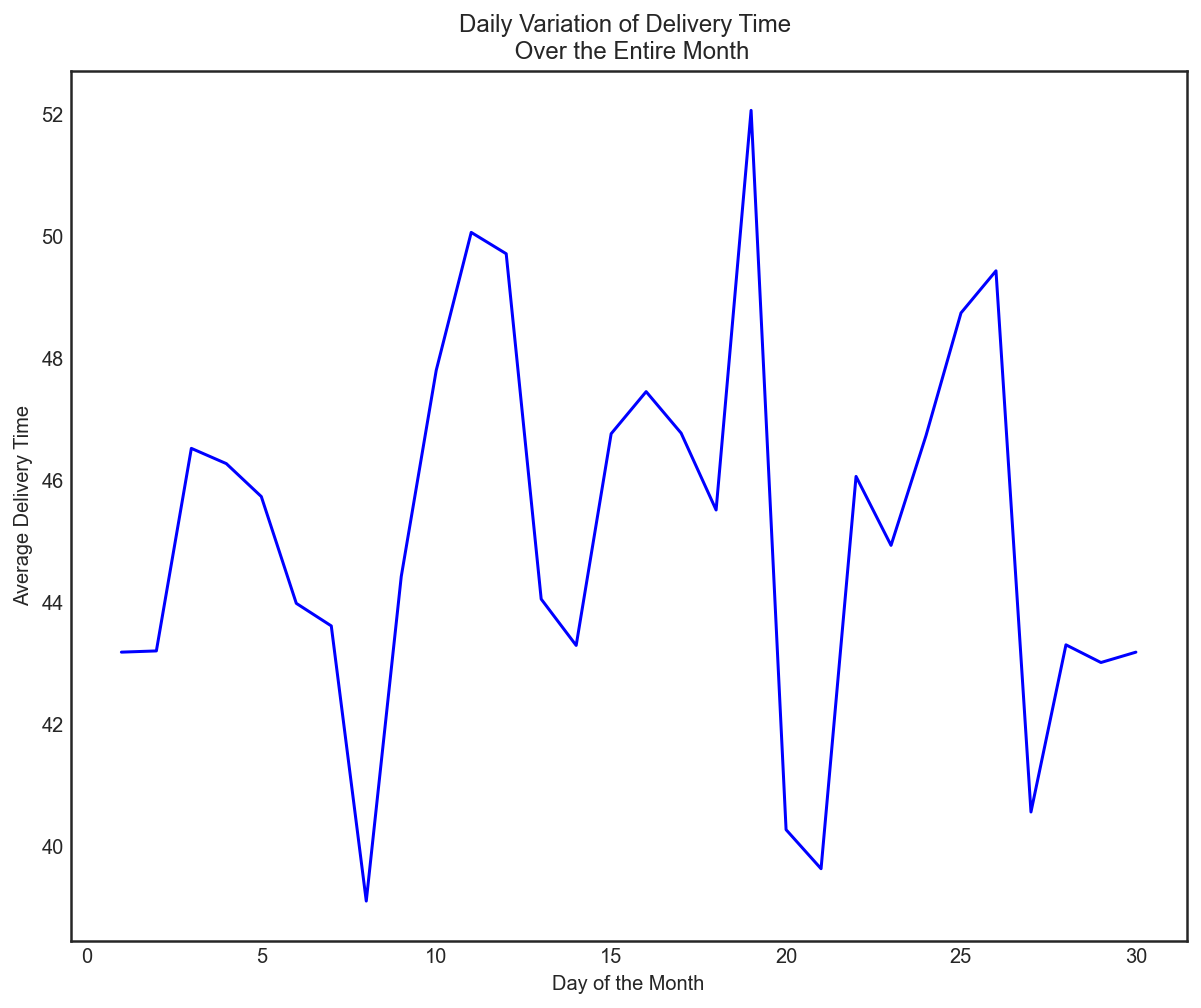

In [23]:
fig, ax = plt.subplots(figsize=(10, 8))  # Create a figure and an axes.
ax.plot(df_average_time['day'],
        df_average_time['avg_order_duration'],
        color='blue')
#plt.axhline(df_average_time['Average_Delivery_Time'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.title("Daily Variation of Delivery Time \n Over the Entire Month")
plt.xlabel("Day of the Month")
plt.ylabel("Average Delivery Time")
plt.show()

#### Food Preparation time
Another factor which often affects whether customers prefer the app or not, is the food preparation time. Depending on the food preparation time, the customers may choose to use or not reuse the app more frequently. To get a basic isight, we will look at the distribution of the food preparation time, in minutes.

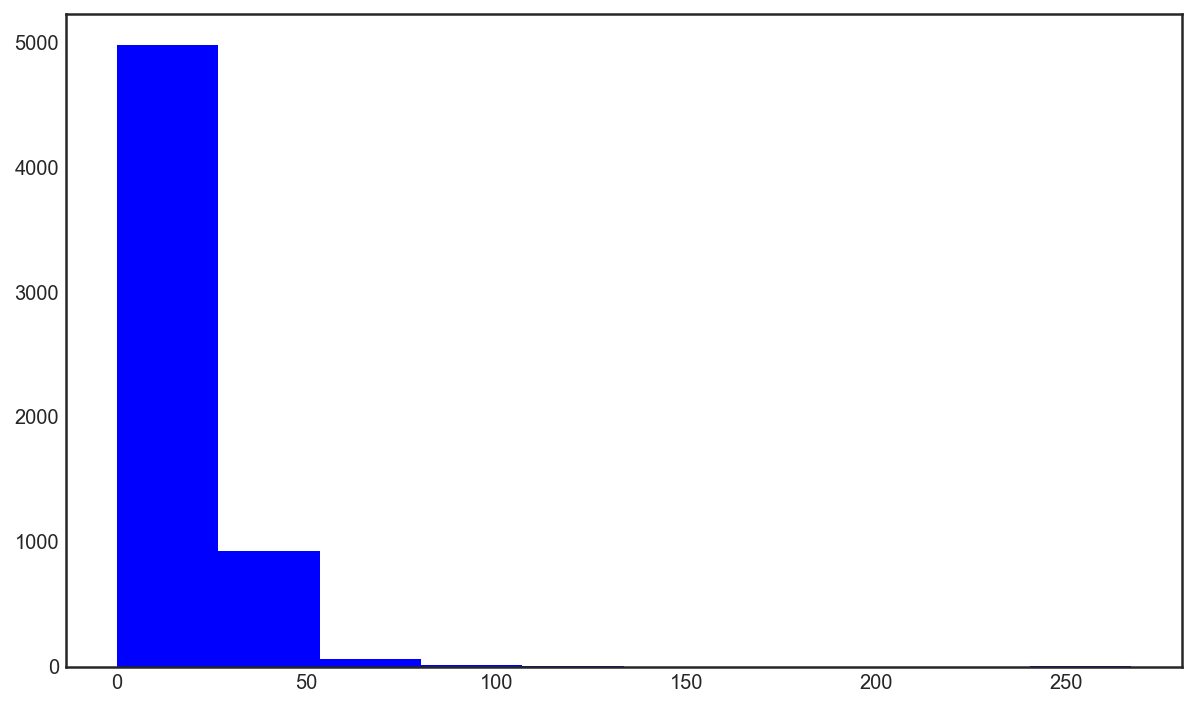

In [24]:
median_food_prep = jumpman_data['food_prep_time'].dropna().median()
fig, ax = plt.subplots(figsize=(10, 6))

plt.hist(jumpman_data['food_prep_time'].replace(np.nan, median_food_prep),
         color='blue')
plt.show()

The ditribution for food preparing time is right skewed, that's a good sign in the sense that the resturants or pick up places with which Jumpman23 has partnered with are prompt responders. The customers will like it for sure.

Since we are looking at food preparation time, it will be more interesting to observe the distribution at different times of the day. This can be useful information in the sense, that for timely service, the app can recommend other options to customers for faster delivery. Initial assumption is that during lunch the food preparation time will be relatively longer. 

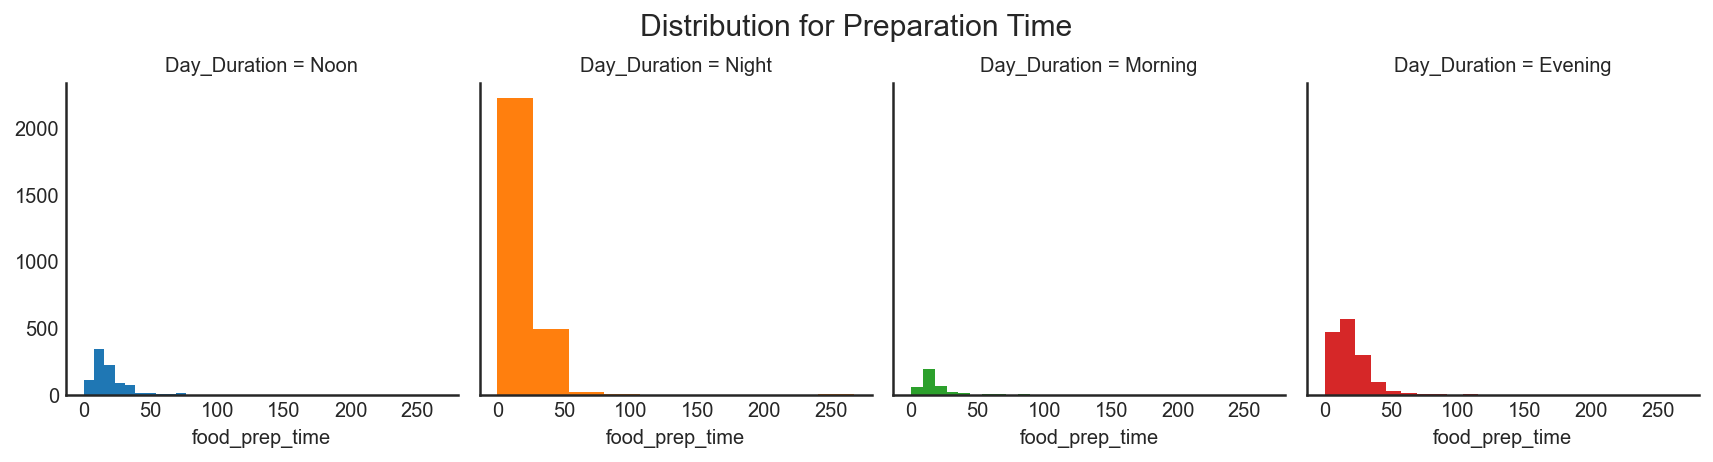

In [25]:
g = sns.FacetGrid(jumpman_data, col="Day_Duration", hue='Day_Duration')
g.fig.suptitle('Distribution for Preparation Time', y=1.05, fontsize=15)
#sns.plt.title('YOUR TITLE HERE')
#plt.title("Distribution of Food Preparation Time Weekday vs. Weekend")
g.map(plt.hist, "food_prep_time")
plt.show()

Above histogram suggests similar pattern in the preparation time irrespective of the time in the day. That's a good sign for the business, i.e. customers don't have to wait long during the weekend for their food. One thing is noticeable that this service is being used in Night a lot, which is reasonable with the food delivery app services. We will revisit it with more details while looking at the map section.

#### Total Delivery time
Next, we will look at one of the most important factors affecting the business, total time from the moment order was made to the time at dropoff.

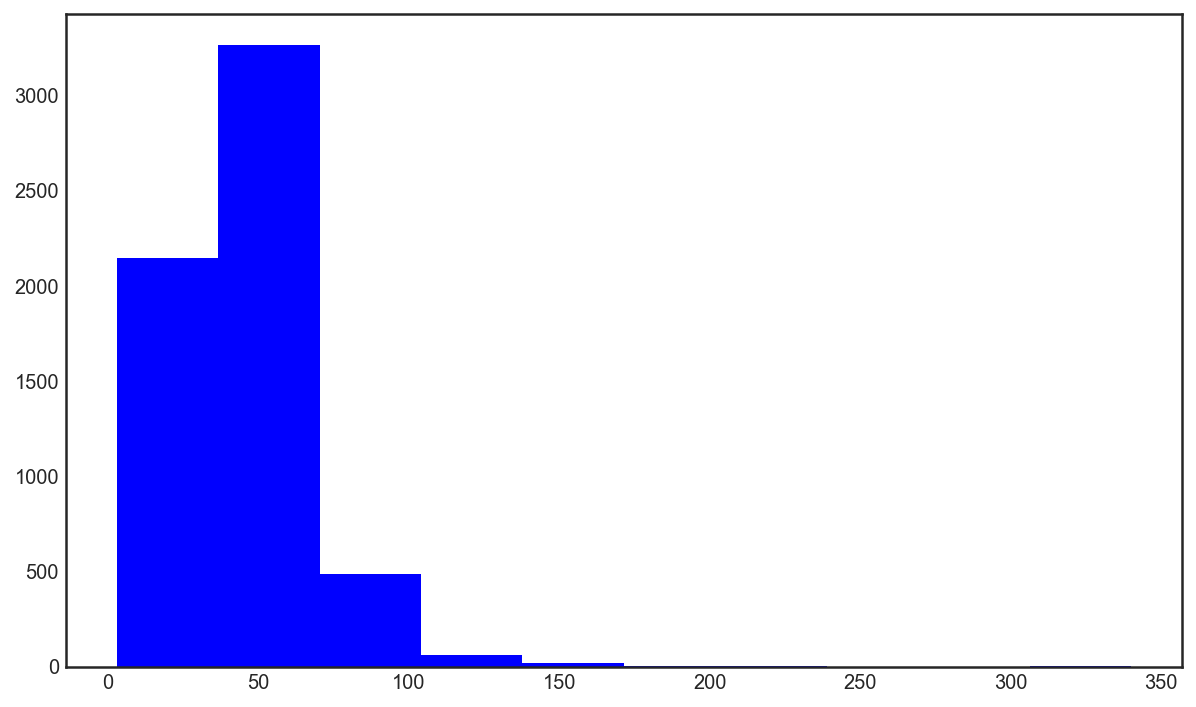

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.hist(jumpman_data['total_time'], color='blue')
plt.show()

In [27]:
jumpman_data['total_time'].describe()

count    5983.000000
mean     45.582651  
std      20.224975  
min      3.000000   
25%      32.000000  
50%      42.000000  
75%      55.000000  
max      340.000000 
Name: total_time, dtype: float64

In [28]:
jumpman_data[jumpman_data['total_time'] ==
             340].loc[:, ['place_category', 'weekday', 'hour']]

,place_category,weekday,hour
1606,American,Friday,23


The above data point with food preparation time of more than 4 hours seems like an outlier. This delivery occured on Friday night at 11p.m, therefore maybe the weekend crowd/traffic may have caused the excess delay. Otherwise the total time taken for the entire process is well within 1 hour.  

Along the same lines we will breakdown the distribution of total delivery time as per the time in the day.

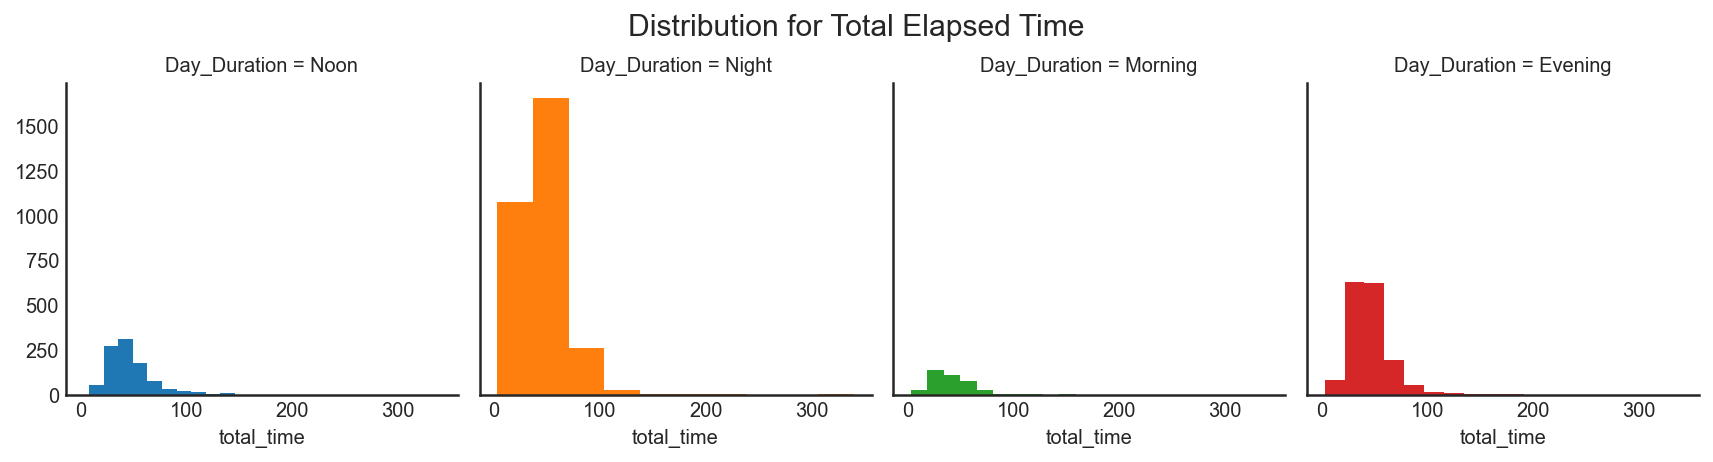

In [29]:
g = sns.FacetGrid(jumpman_data, col="Day_Duration", hue='Day_Duration')
g.fig.suptitle('Distribution for Total Elapsed Time', y=1.05, fontsize=15)
#sns.plt.title('YOUR TITLE HERE')
#plt.title("Distribution of Food Preparation Time Weekday vs. Weekend")
g.map(plt.hist, "total_time")
plt.show()

The distribution looks similar at first sight during difernt times of the day. It will be interesting to look at this in the maps section, taking into account the geographical locations.

In the above section, we looked at the overall performance of KPI's, and learnt the following; 

* First, the business is showing signs of growth in New York City, evident by increase in daily average of orders placed,

* Second, average hourly deliveries is significantly higher over the weekends and it has an upward trend,

* Third, average order duration is well within an hour.

We will revisit above KPI's at a more detailed level, in the section on maps. We will look at the trends of above KPI's for different locations and restaurants.

### Food Category and Time
It will be interesting to see which categories of pickup places are more popular among New York customers, and around which time of the day. To this end, we will compute percentage of deliveries and drop off for each place category. One idea can be to impute the missing values in the column `place_category`. It is standard to use it as a new category, `Other`.

In [30]:
jumpman_data['place_category'] = jumpman_data['place_category'].replace(
    np.nan, 'Other')

In [31]:
category_time_cnt = jumpman_data.groupby(['place_category', 'Day_Duration'
                                          ])['delivery_id'].count()
category_time_cnt.shape

In [32]:
category_time_cnt = pd.DataFrame(category_time_cnt).reset_index()

category_time_cnt.rename(columns={'delivery_id': 'delivery_cnt'}, inplace=True)

In [33]:
time_delivery = category_time_cnt.groupby(['Day_Duration'
                                           ])['delivery_cnt'].sum()
time_delivery = pd.DataFrame(time_delivery).reset_index()
time_delivery.rename(columns={'delivery_cnt': 'Total_delivery'}, inplace=True)
time_delivery

In [34]:
data_joined = pysqldf(
    '''SELECT DISTINCT tab1.Day_Duration, tab2.place_category, tab2.delivery_cnt, 
                      tab1.Total_delivery
                      FROM time_delivery AS tab1 
                     JOIN category_time_cnt AS tab2 
                     ON tab1.Day_Duration=tab2.Day_Duration;''')
data_joined['Percent_delivery'] = np.round(
    (data_joined['delivery_cnt'] / data_joined['Total_delivery']) * 100, 2)

In [35]:
top5_places = pysqldf(''' SELECT Day_Duration,
                               place_category,
                               Percent_delivery
                               
                  FROM (SELECT Day_Duration,
                   Percent_delivery,
                   place_category,
                   RANK() OVER(PARTITION BY Day_Duration ORDER BY Percent_delivery DESC) AS ranking
                   FROM data_joined)
                   WHERE ranking<=5''')
top5_places

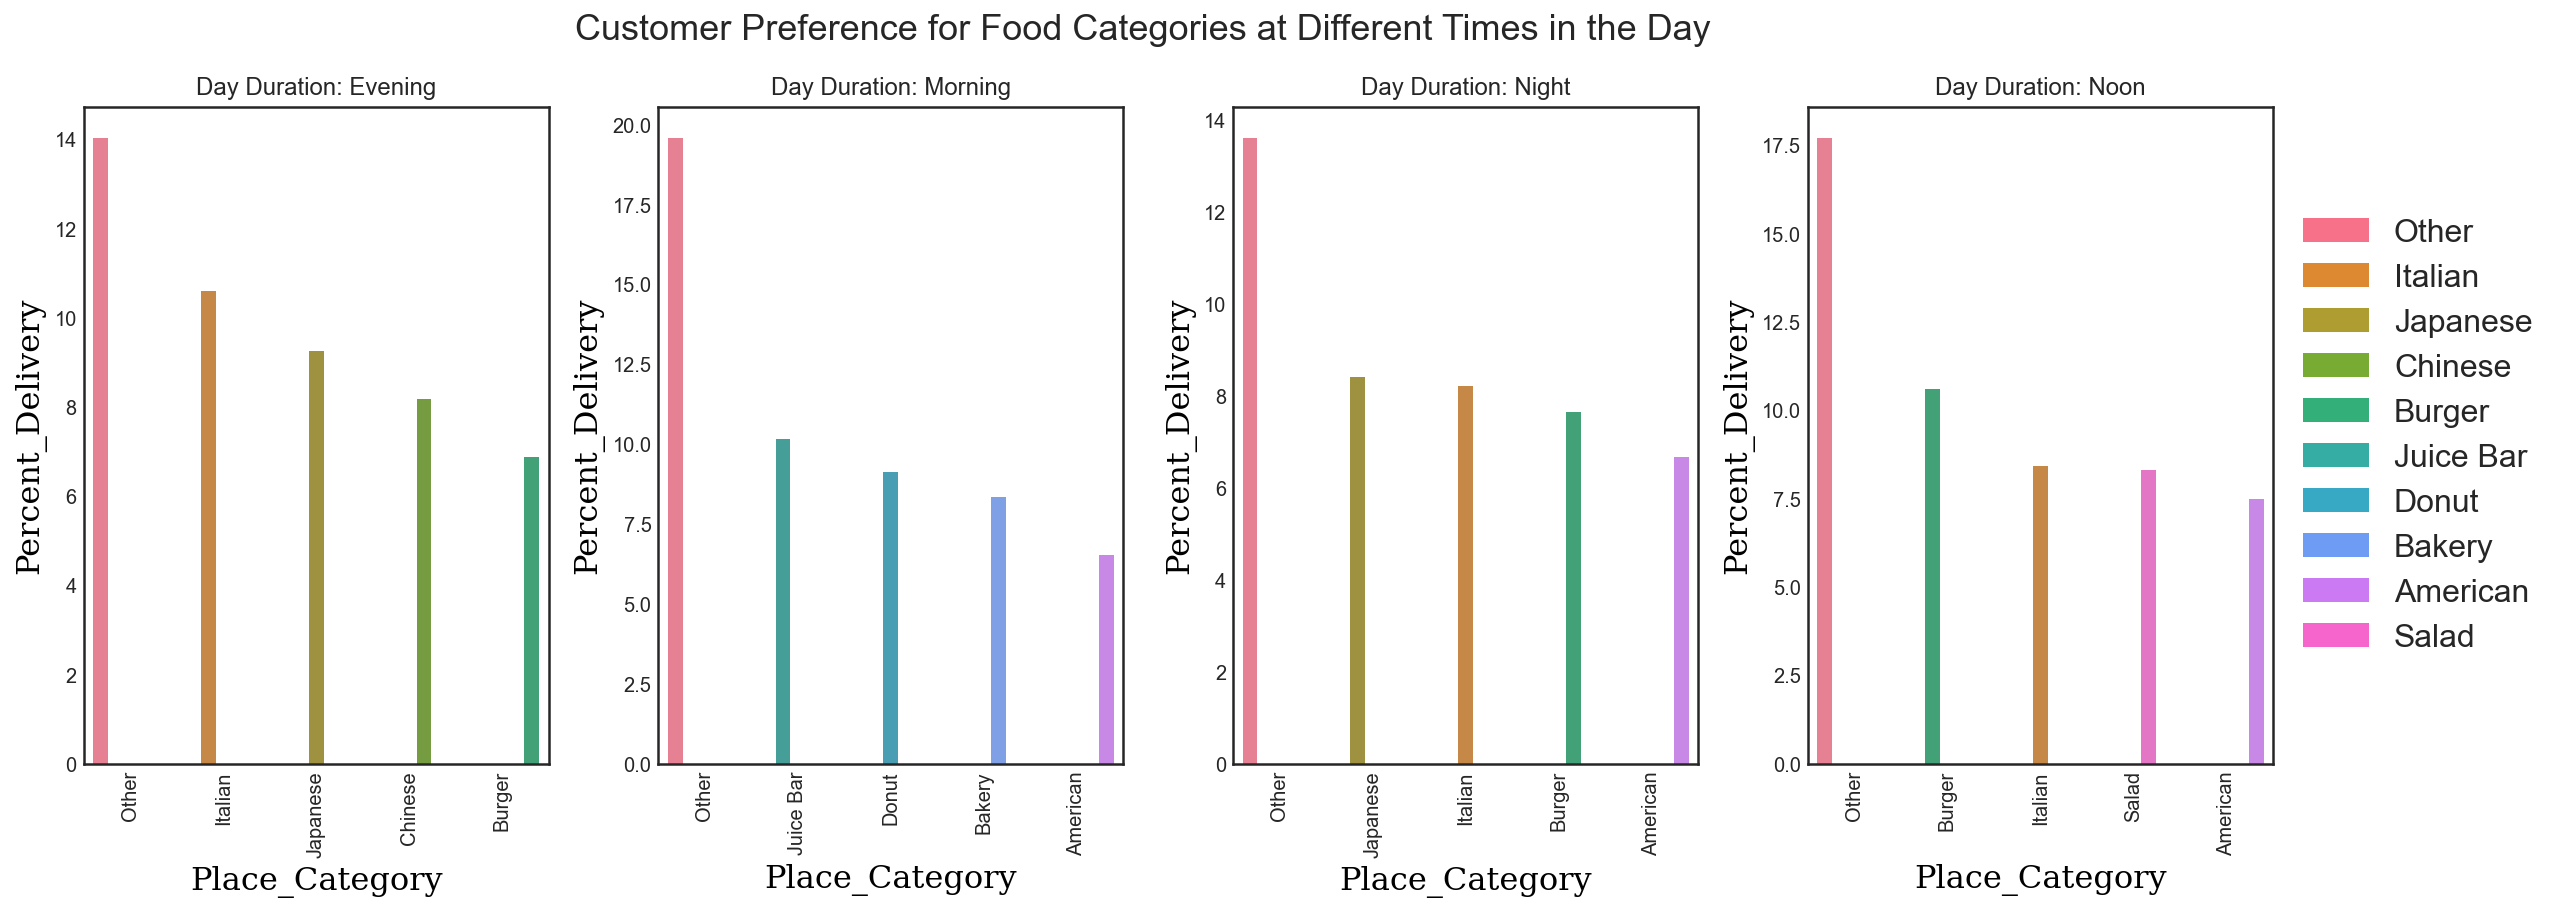

In [36]:
from matplotlib.patches import Patch

# create a color map for unique values or place
place_cat = top5_places.place_category.unique()
colors = sns.color_palette('husl', n_colors=10)
cmap = dict(zip(place_cat, colors))
font = {
    'family': 'serif',
    'color': 'black',
    'weight': 'normal',
    'size': 16,
}

# plot a subplot for each Day_Duration
plt.figure(figsize=(16, 6))
for i, tod in enumerate(top5_places.Day_Duration.unique(), 1):
    data = top5_places[top5_places.Day_Duration == tod].sort_values(
        ['Percent_delivery'], ascending=False)
    plt.subplot(1, 4, i)
    p = sns.barplot(x='place_category',
                    y='Percent_delivery',
                    data=data,
                    hue='place_category',
                    palette=cmap)
    p.legend_.remove()
    plt.xticks(rotation=90)
    plt.title(f'Day Duration: {tod}')
    plt.xlabel('Place_Category', fontdict=font)
    plt.ylabel('Percent_Delivery', fontdict=font)

plt.tight_layout()
patches = [Patch(color=v, label=k) for k, v in cmap.items()]
plt.legend(handles=patches,
           bbox_to_anchor=(1.04, 0.5),
           loc='center left',
           fontsize=16,
           borderaxespad=0)
plt.suptitle('Customer Preference for Food Categories at \
Different Times in the Day',
             y=1.05,
             fontsize=18)
plt.show()

From the above barplot, it is easy to deduce that duration of the day does influence the taste of the customers. For example, during morning, the preferred categories are Juice bar, or Bakery. This aligns with our intuition.

### Delivery Time at Different Times of the Day

It is expected that the total delivery time should be correlated with the food prepration time. It will be nice to make sure it holds true by looking at few scatterplots.

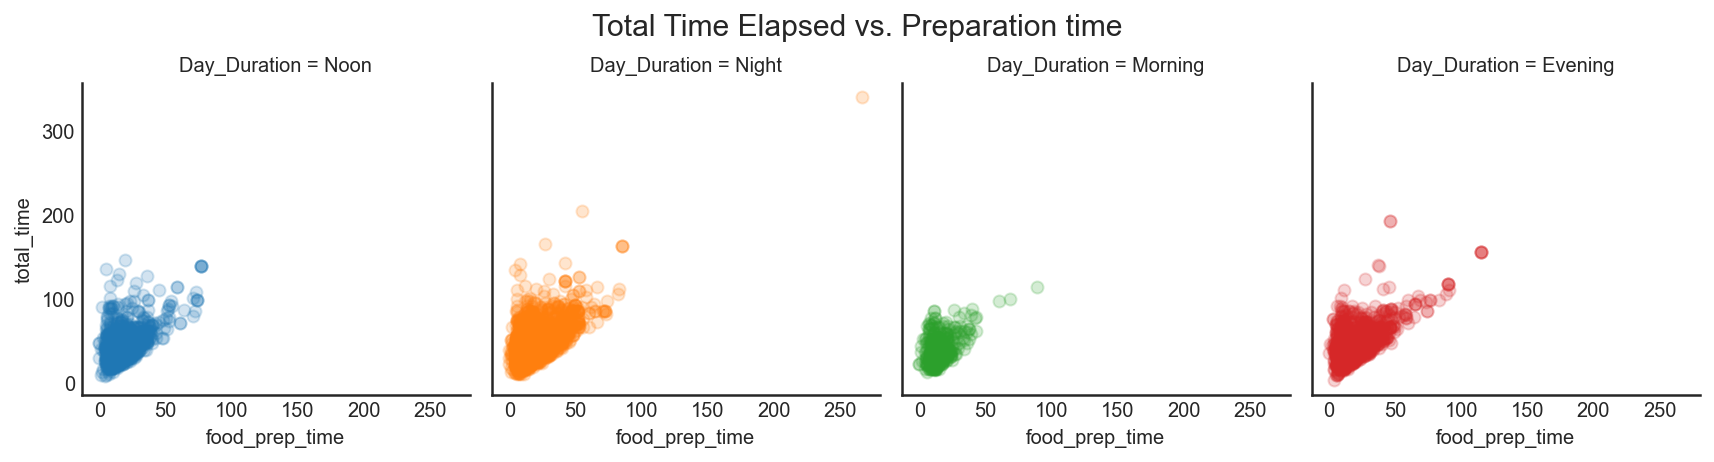

In [37]:
g = sns.FacetGrid(jumpman_data, col="Day_Duration", hue='Day_Duration')
g.fig.suptitle('Total Time Elapsed vs. Preparation time', y=1.05, fontsize=15)
#sns.plt.title('YOUR TITLE HERE')
#plt.title("Distribution of Food Preparation Time Weekday vs. Weekend")
g.map(plt.scatter, "food_prep_time", "total_time", alpha=0.2)
plt.show()

Above scatterplots show that most of the deliveries had food preparation time less than 50 minutes, we we saw earlier also in the histograms. It will be interesting to see the trend in total time vs. food preparation time on a subset of the data.

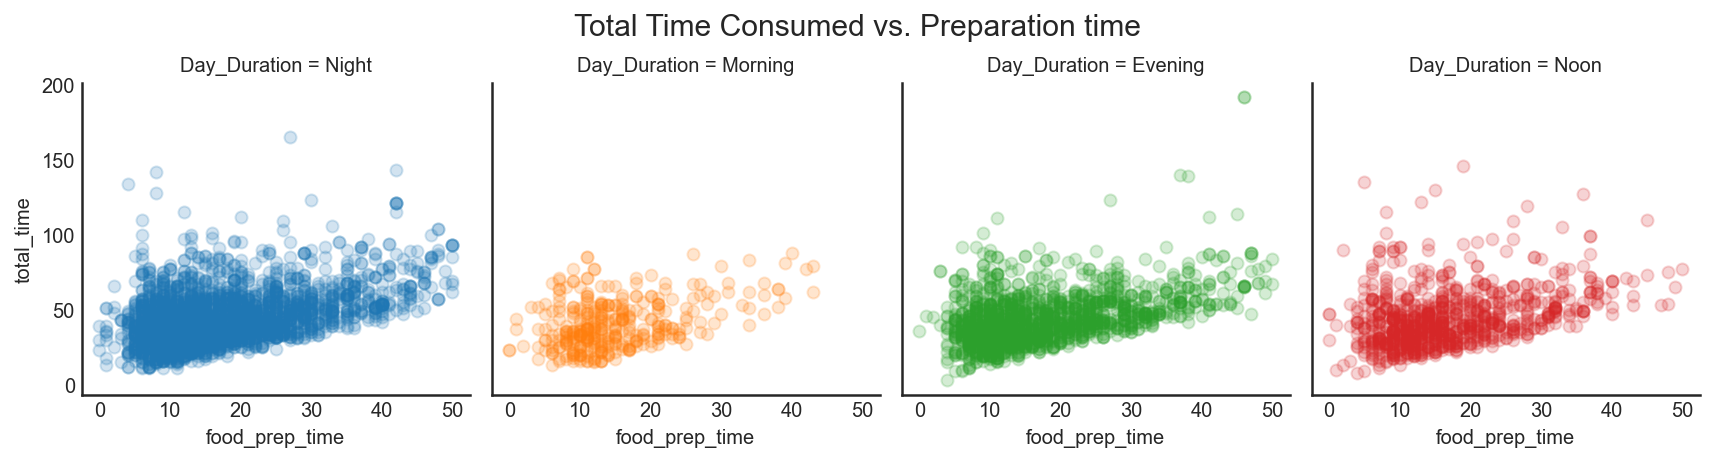

In [38]:
g = sns.FacetGrid(jumpman_data[jumpman_data['food_prep_time'] <= 50],
                  col="Day_Duration",
                  hue='Day_Duration')
g.fig.suptitle('Total Time Consumed vs. Preparation time', y=1.05, fontsize=15)
#sns.plt.title('YOUR TITLE HERE')
#plt.title("Distribution of Food Preparation Time Weekday vs. Weekend")
g.map(plt.scatter, "food_prep_time", "total_time", alpha=0.2)
plt.show()



## Does Restaurant Locations Affect Customer's behavior?

Earlier, we observed few KPI's and their overall trend in the month of October 2014. Now in this section, we plan to dig deeper into those kPI's and look at their behavior in different parts of the city. 
It will be useful to compute the distance information between the pickup and dropoff locations.

In [39]:
 R = 6371e3; # Earth's radius in metres
jumpman_data['pickup_lat_rad'] = jumpman_data['pickup_lat']*(math.pi/180)
jumpman_data['dropoff_lat_rad'] = jumpman_data['dropoff_lat']*(math.pi/180)

jumpman_data['lat_diff'] = (jumpman_data['pickup_lat'] -jumpman_data['dropoff_lat'])* (math.pi/180) # φ, λ in radians
jumpman_data['lon_diff'] = (jumpman_data['pickup_lon'] - jumpman_data['dropoff_lon'])* (math.pi/180)
#const Δφ = (lat2-lat1) * Math.PI/180;
#const Δλ = (lon2-lon1) * Math.PI/180;

jumpman_data['a'] = (np.sin(jumpman_data['lat_diff']/2) * np.sin(jumpman_data['lat_diff']/2)) + \
          (np.cos(jumpman_data['pickup_lat_rad']) * np.cos(jumpman_data['dropoff_lat_rad']) * \
          np.sin(jumpman_data['lon_diff']/2) * np.sin(jumpman_data['lon_diff']/2));
jumpman_data['c'] = 2 * np.arctan(np.sqrt(jumpman_data['a'])/ np.sqrt(1-jumpman_data['a']));
#jumpman_data['d'] = 2 *(np.sqrt(jumpman_data['a'])/ np.sqrt(1-jumpman_data['a']))

jumpman_data['dist'] = R * jumpman_data['c']; # in metres

In [40]:
jumpman_data.drop(['pickup_lat_rad','dropoff_lat_rad','lat_diff','lon_diff','a','c'],axis=1,inplace=True)
jumpman_data.head(3);

### Distance Travelled by the Jumpmen

Now that we know the distance between the pick up location and drop off locations, it make sense to look at the distribution of distance covered by the jumpman delivery guys. In particular, we will look at the distribution corresponding to different vehicle types.

In [41]:
jumpman_data['vehicle_type'].unique()

array(['van', 'bicycle', 'car', 'walker', 'truck', 'scooter',
       'motorcycle'], dtype=object)

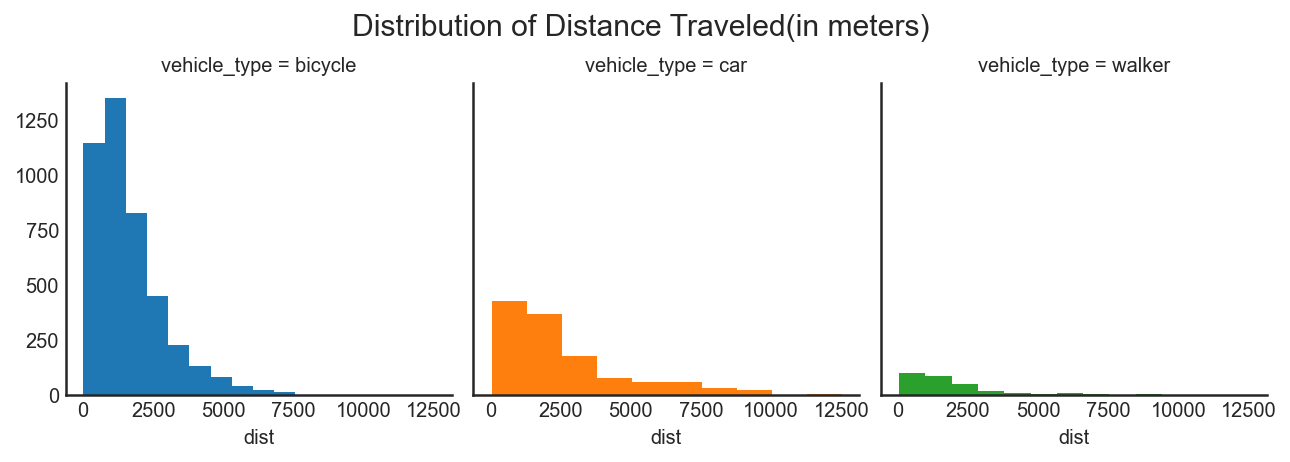

In [42]:
g = sns.FacetGrid(jumpman_data[jumpman_data['vehicle_type'].isin(['bicycle','car','walker'])],\
                               col='vehicle_type',hue='vehicle_type')
g.fig.suptitle('Distribution of Distance Traveled(in meters)', y=1.05, fontsize=15)
#sns.plt.title('YOUR TITLE HERE')
#plt.title("Distribution of Food Preparation Time Weekday vs. Weekend")
g.map(plt.hist, "dist")
plt.show()

The distance travelled is right skewed as expected. It will be interestig to look at distance based KPI, what percentage of deliveries are made by cars. This can help us to decide whether we need to partner with more neighborhood restaurants. Moreover it tells us, whether the service is eco-friendly or not.

In [43]:
gb_vehicle=jumpman_data[jumpman_data['vehicle_type'].isin(['bicycle','car'])].groupby(['day','vehicle_type'])
vehicle_data=gb_vehicle['delivery_id'].count().reset_index()
vehicle_data.rename(columns={'delivery_id':'Delivery_Cnt'},inplace=True);

In [44]:
day_gb=vehicle_data.groupby('day')
day_delivery_data=day_gb['Delivery_Cnt'].sum().reset_index()
day_delivery_data;

In [45]:
joined_data=pd.merge(left=vehicle_data,right=day_delivery_data,how='inner',left_on='day',right_on='day')
joined_data['delivery_pct']=(joined_data['Delivery_Cnt_x']/joined_data['Delivery_Cnt_y'])*100
joined_data;

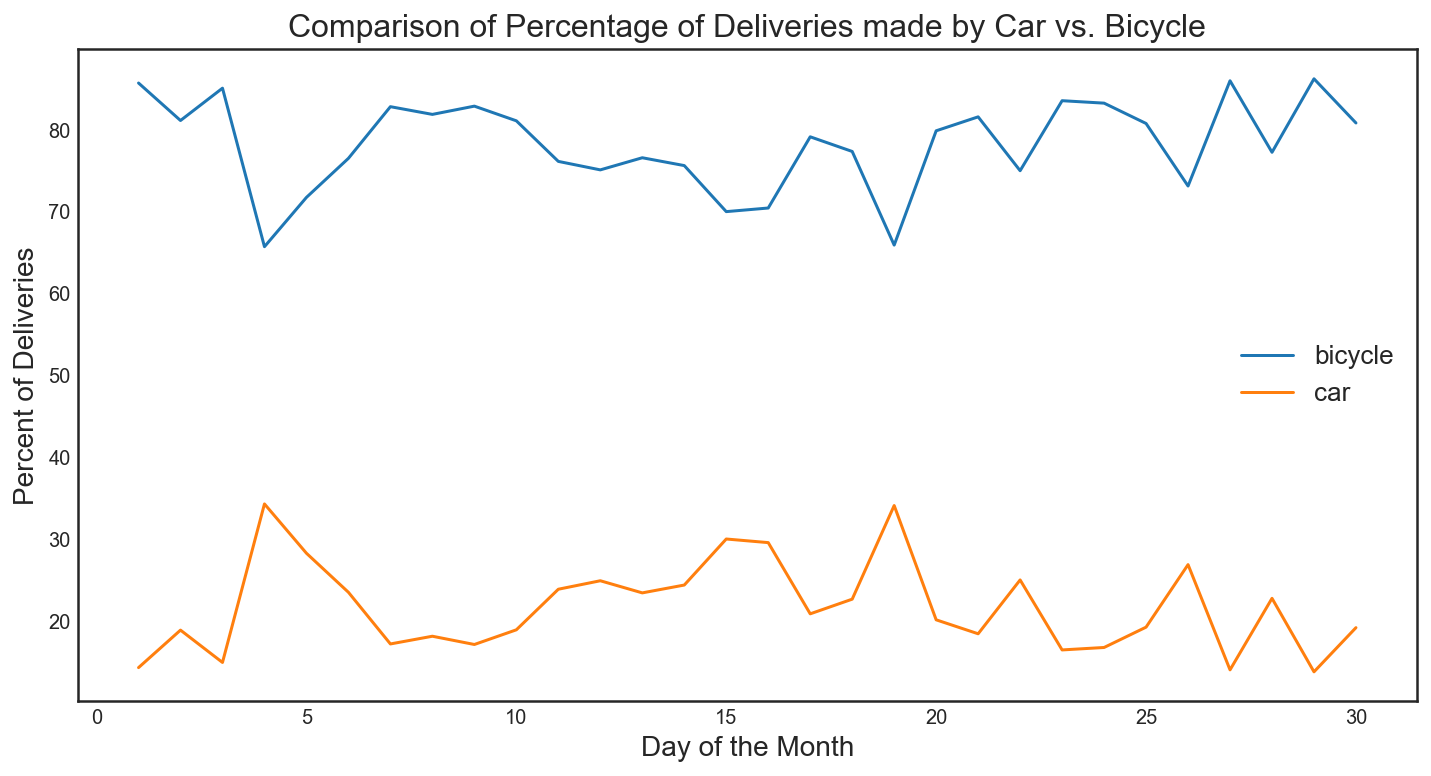

In [46]:
groups= joined_data.groupby('vehicle_type')
# Plot
plt.figure(figsize=(12,6))
#ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    plt.plot(group.day, group.delivery_pct, ms=12, label=name)
plt.legend(fontsize=13)
plt.xlabel("Day of the Month",fontsize=14)
plt.ylabel("Percent of Deliveries",fontsize=14)
plt.title("Comparison of Percentage of Deliveries made by Car vs. Bicycle",fontsize=16)
plt.style.use('seaborn-white')
plt.show()
#groups

From the above line chart, we deduce that overall bicycles are being used more frequently for deliveries, which means that the drop off locations are not terribly far from the pickup locations. Moreover, it implies this delivery platform is more eco-friendly which is preferred by the customers.

Next, we will use some geographical information to compare the KPI's at different locations/boroughs.

### Data Preparation for Processing Geograhical Information

In [47]:
#import geopandas as gpd
map_data=gpd.read_file('geo_export_8175dadf-c3ec-4a0d-90a1-ed85a78fb0af.shp')
map_data.head(3);

In [48]:
map_data["rep"] = map_data["geometry"].representative_point()
map_points = map_data.copy()
map_points.set_geometry("rep", inplace = True)

In [49]:
crs = {'init': 'epsg:4326'} #co-ordinate reference system

In [50]:
geometry = [Point(xy) for xy in zip(jumpman_data['pickup_lon'], jumpman_data['pickup_lat'])]
geo_df = gpd.GeoDataFrame(jumpman_data, crs = crs, geometry = geometry)
restaurants_boroughs = gpd.sjoin(map_data,geo_df, how="inner", op='contains')

In [51]:
restaurants_boroughs.drop(['geometry'],axis=1,inplace=True)

In [52]:
pickup_geometry = [Point(xy) for xy in zip(restaurants_boroughs['pickup_lon'], restaurants_boroughs['pickup_lat'])]
geo_df = gpd.GeoDataFrame(restaurants_boroughs, crs = crs, geometry = pickup_geometry)

As a result of above preparatory steps, we obtain the geodataframe `geo_df`, which has the information regarding the Borough in which the retaurant is located. Now we will address the KPI's listed in the first section and investigate them on the borough level.

#### Average Number of Daily Deliveries
To begin with, we will look at the trend in the average number of daily deliveries made in different boroughs.

In [53]:
geo_df.columns;

In [54]:
geo_df['boro_name'].unique()

array(['Manhattan', 'Brooklyn', 'Queens'], dtype=object)

In [55]:
geo_df_copy=geo_df.copy()
df=pd.DataFrame((geo_df_copy.drop(columns=['geometry','rep'])))
type(df);

In [56]:
weekly_boro_count=pysqldf(''' SELECT weeks, boro_name, COUNT(delivery_id) AS order_cnt, \
                             COUNT(delivery_id)/7 AS daily_avg \
                             FROM df \
                             GROUP BY weeks,boro_name;''')
weekly_boro_count.shape;

<Figure size 864x432 with 0 Axes>

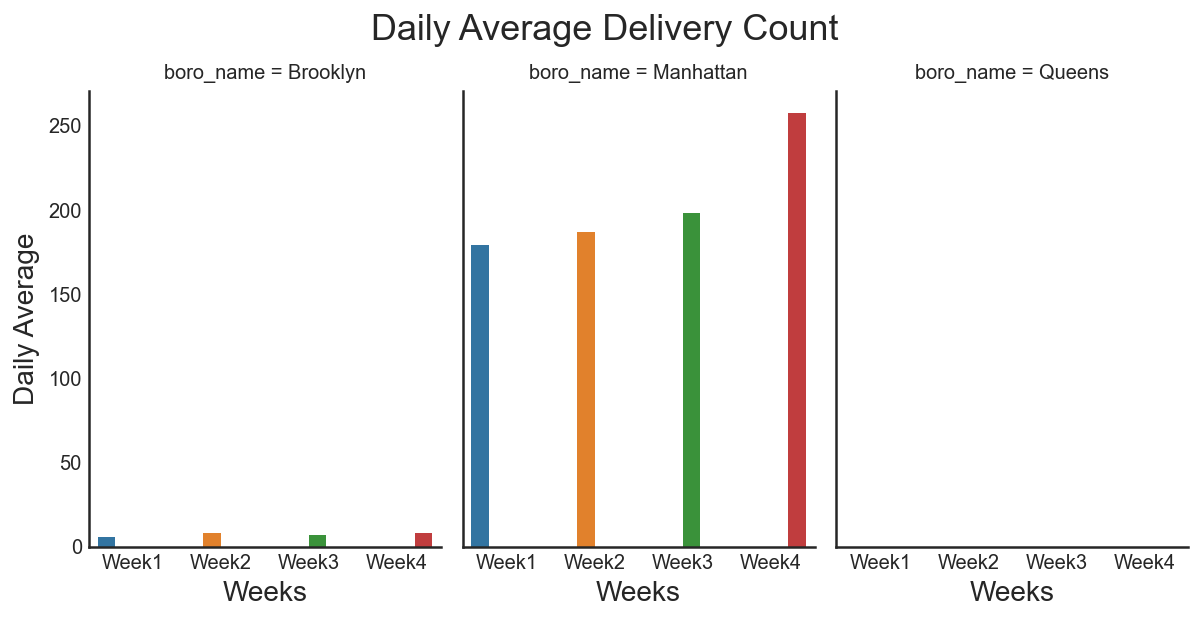

In [57]:
plt.figure(figsize=(12,6))
g = sns.catplot(x="weeks", y="daily_avg",
                hue="weeks", col="boro_name",
                data=weekly_boro_count, kind="bar",
             height=4, aspect=.7)
plt.suptitle('Daily Average Delivery Count',y=1.05,fontsize=18)
g.set_xlabels('Weeks',fontsize=14)
g.set_ylabels('Daily Average',fontsize=14)
plt.show()

Above barplot suggests that the business is doing good in the Manhattan area, but not so much presence is being observed in Brooklyn and Queens. It will be helpful to do a quick check on the map, do we have enough restaurants in partnership in Brooklyn and Queens.

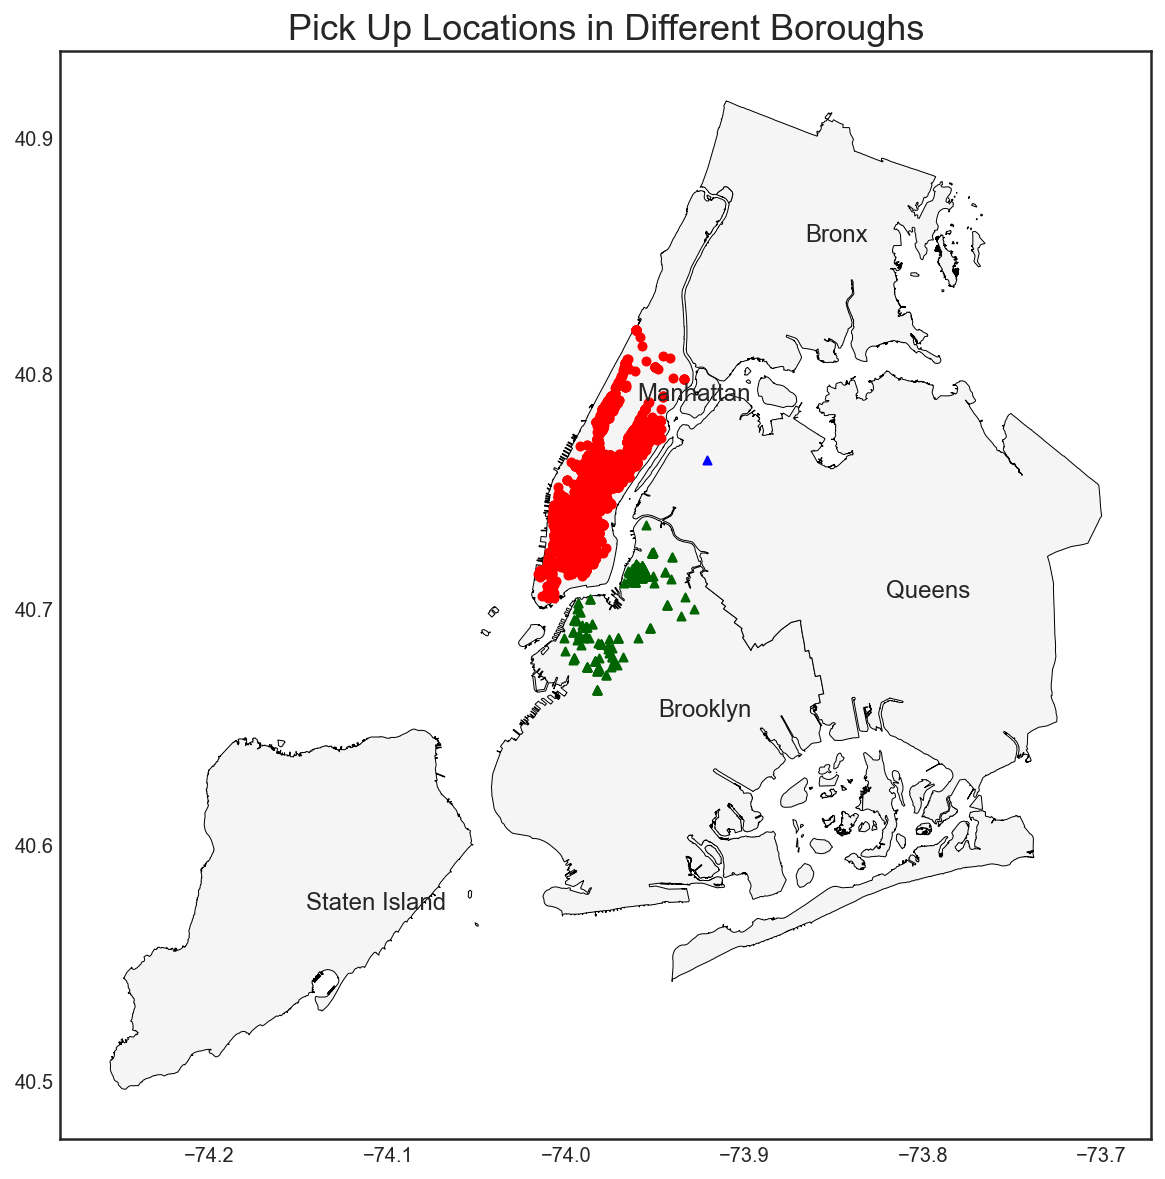

In [58]:
#fig, ax = plt.subplots(figsize = (16,16))
ax = map_data.plot(figsize = (12, 10), color = "whitesmoke", edgecolor = "black", linewidth = 0.5)
texts = []

for x, y, label in zip(map_points.geometry.x, map_points.geometry.y, map_points["boro_name"]):
    texts.append(plt.text(x, y, label, fontsize = 12))

#aT.adjust_text(texts, force_points=0.3, force_text=0.8, expand_points=(1,1), expand_text=(1,1), 
 #              arrowprops=dict(arrowstyle="-", color='grey', lw=0.5))
#map_data.plot(ax=ax, alpha = 0.1, color='grey',edgecolor='green')
geo_df[geo_df['boro_name'] == 'Manhattan'].plot(ax = ax, color = 'red', marker = 'o', markersize = 16)

geo_df[geo_df['boro_name'] == 'Brooklyn'].plot(ax = ax, color = 'darkgreen', marker = "^", markersize = 16)


geo_df[geo_df['boro_name'] == 'Queens'].plot(ax = ax, color = 'blue', marker = "^", markersize = 16)
plt.title("Pick Up Locations in Different Boroughs",fontsize=18)
plt.show()

Going by the above map, it is easy to see that Manhattan has a significantly higher concentration of restaurants with which the food app has partnerd with, hence causing increase in weekly deliveries in that region. But it should be kept in mind that Brooklyn is more than three times the area of Manhattan. That should be taken into account while looking at the above visual.

#### Average Item Count Per Delivery
Second, we will compare the average item count per delivery across different districts. It will tell us are the people really liking the service as well as restaurants recommended by the app.

In [59]:
item_cnt_boro=pysqldf('''SELECT boro_name, day, \
                              COUNT(*) AS order_cnt, SUM(item_quantity),
                              SUM(item_quantity)/COUNT(*) AS item_cnt_per_delivery \
                              FROM df 
                              GROUP BY boro_name,day;''')
item_cnt_boro.shape;

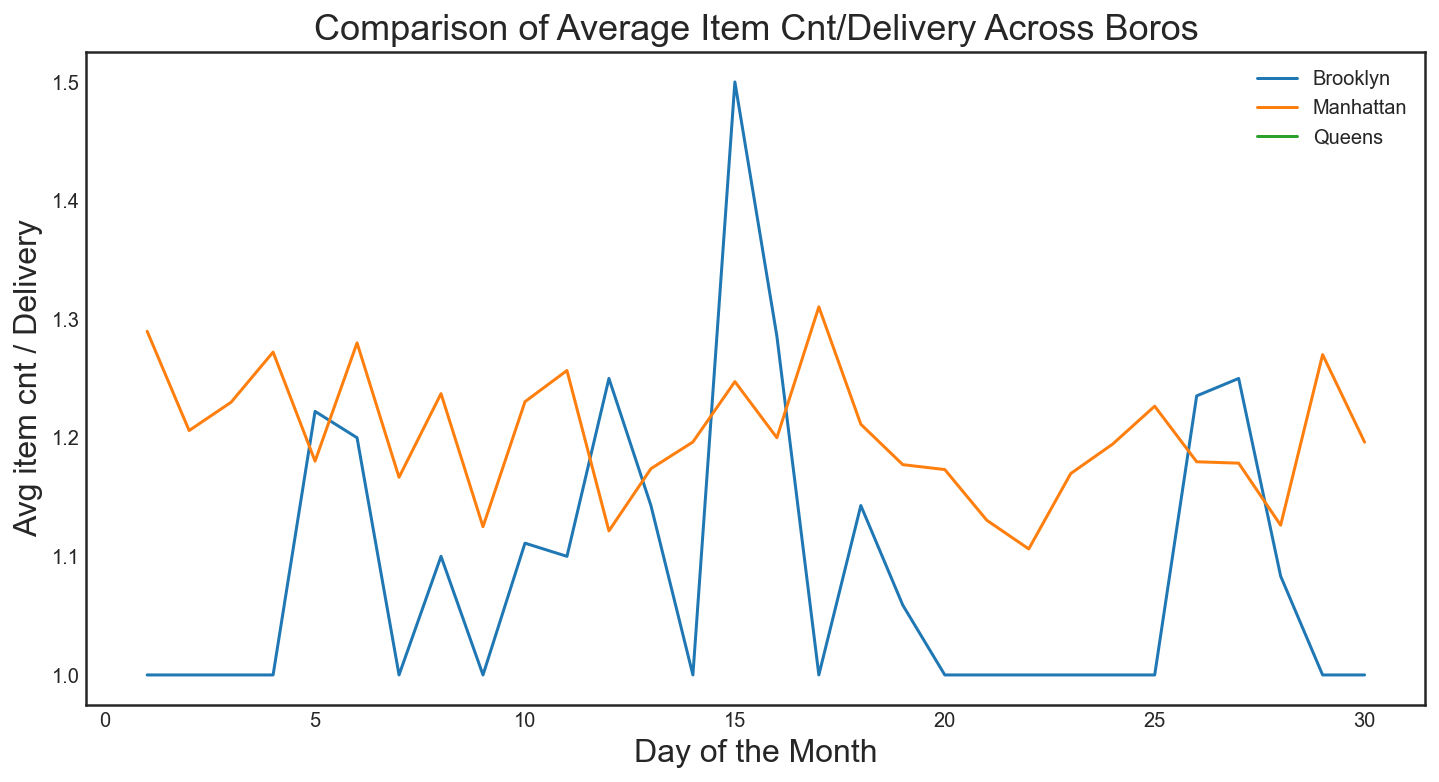

In [60]:
groups= item_cnt_boro.groupby('boro_name')
# Plot
plt.figure(figsize=(12,6))
#ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    plt.plot(group.day, group.item_cnt_per_delivery, ms=12, label=name)
plt.legend()
plt.xlabel("Day of the Month",fontsize=16)
plt.ylabel("Avg item cnt / Delivery",fontsize=16)
plt.title("Comparison of Average Item Cnt/Delivery Across Boros",fontsize=18)
plt.style.use('seaborn-white')
plt.show()
#groups

Above line plot sugests that the restaurants in both Brooklyn and Manhattan are quite comparable in the item count per delivery. The good news is that it is quite consistent throughout the month.

#### Average Hourly Deliveries

Next we will look at the KPI, average hourly orders made throughout the month across different boros. Earlier we saw that the weekends see a spike in hourly average orders. It will be interesting to look at the behavior across the different neighborhoods. 

In [61]:
gb_df=df.groupby(['day','weekday','boro_name'])
daily_df_cnt=gb_df.agg({'delivery_id':np.count_nonzero}).reset_index()
daily_df_cnt.rename(columns={'delivery_id':'Total_count'},inplace=True)
daily_df_cnt['delivery_per_hour']=round(daily_df_cnt['Total_count']/24,2)

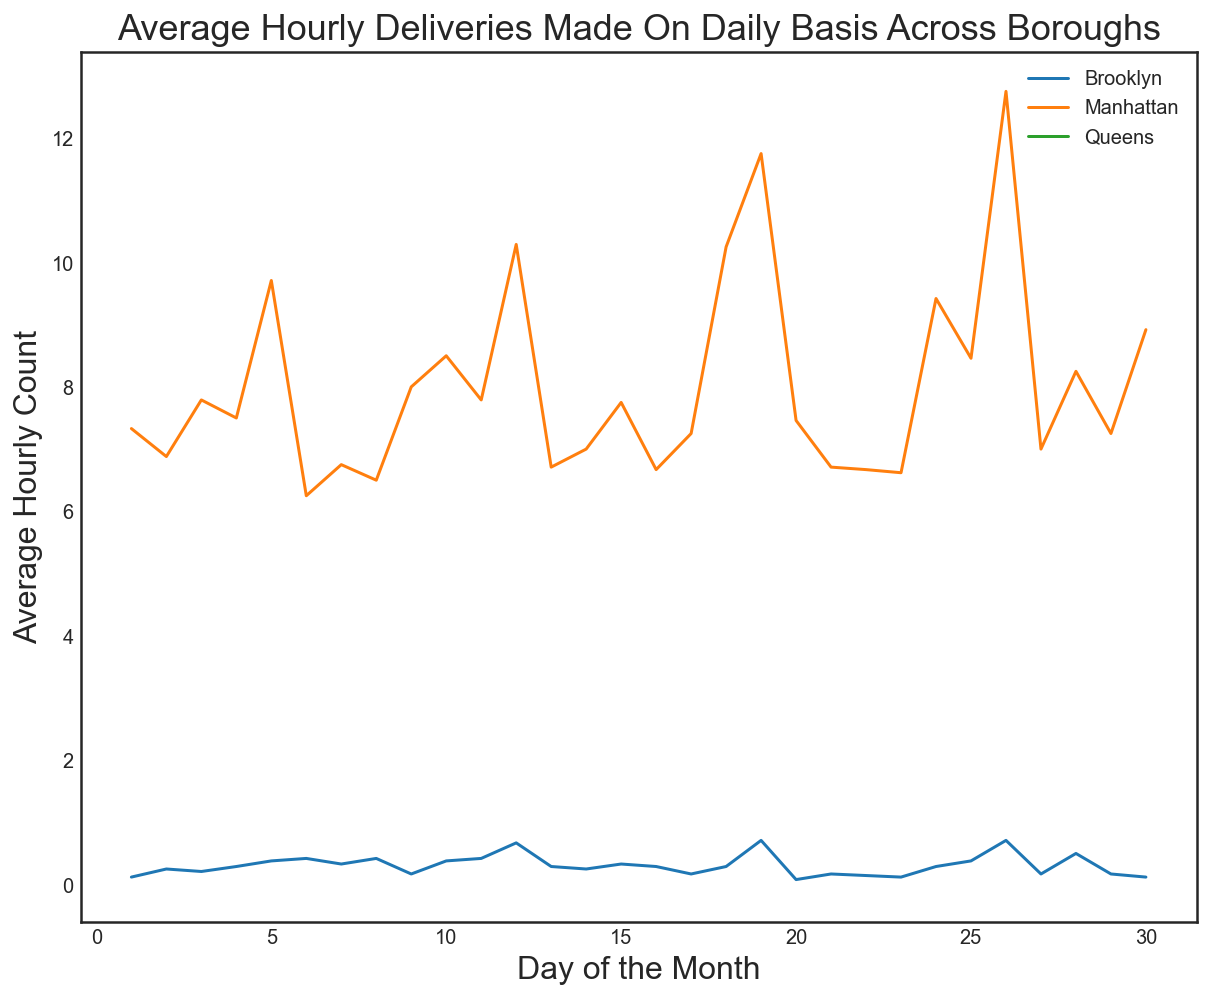

In [62]:
groups= daily_df_cnt.groupby('boro_name')
fig, ax = plt.subplots(figsize=(10,8))  # Create a figure and an axes.

for name, group in groups:
    plt.plot(group.day, group.delivery_per_hour, ms=12, label=name)
#ax.plot(daily_df_cnt['day'],daily_df_cnt['delivery_per_hour'],color='blue')
#plt.axhline(daily_cntai['cnt_per_delivery'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.legend()
plt.title("Average Hourly Deliveries Made On Daily Basis Across Boroughs",fontsize=18)
plt.xlabel("Day of the Month",fontsize=16)
plt.ylabel("Average Hourly Count",fontsize=16)
plt.show()

As observed earlier, weekends do see a spike in average hourly deliveries, moreover the business seems to be quite healthy in Manhattan. It can be atributed to the large number of restaurants with which the food delivery app has partnered with. 

#### Average Order Duration
Third, is the service fast enough in Manhattan? To answer this query, we look at average order duration, which is defined as total time spent divided by number of deliveries made on a given day.

In [63]:
df_gb=df.groupby(['day','boro_name'])
df_avg_time=df_gb.agg({'total_time':np.sum,'delivery_id':np.count_nonzero}).reset_index()
df_avg_time.rename(columns={'total_time':'Delivery_Time','delivery_id':'Delivery_cnt'},inplace=True)
df_avg_time['avg_order_duration']=np.round(df_avg_time['Delivery_Time']/df_avg_time['Delivery_cnt'],2)

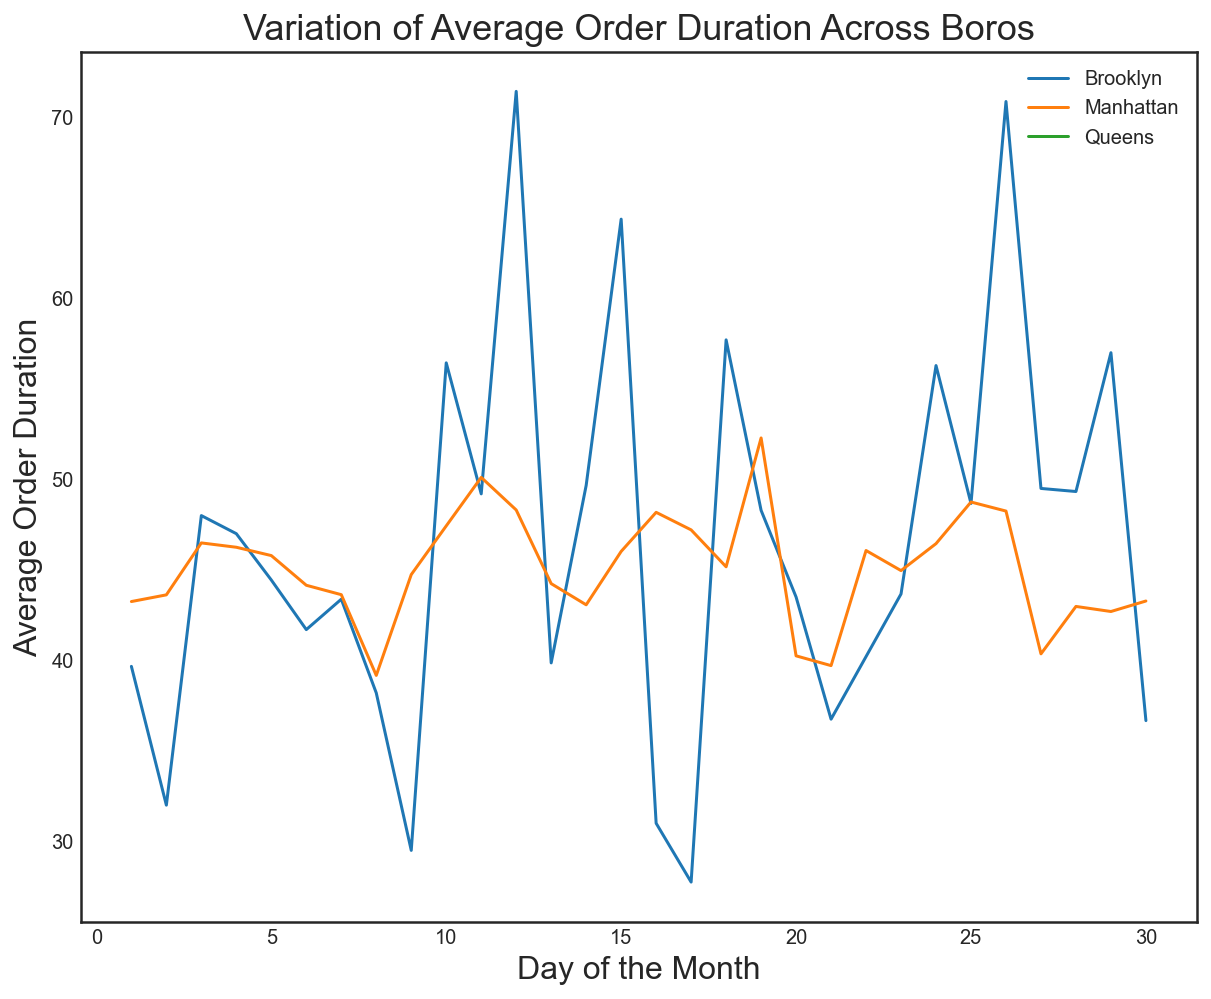

In [64]:
groups= df_avg_time.groupby('boro_name')
fig, ax = plt.subplots(figsize=(10,8))  # Create a figure and an axes.

for name, group in groups:
    plt.plot(group.day, group.avg_order_duration, ms=12, label=name)
#ax.plot(daily_df_cnt['day'],daily_df_cnt['delivery_per_hour'],color='blue')
#plt.axhline(daily_cntai['cnt_per_delivery'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.legend()
plt.title("Variation of Average Order Duration Across Boros",fontsize=18)
plt.xlabel("Day of the Month",fontsize=16)
plt.ylabel("Average Order Duration",fontsize=16)
plt.show()

In Brooklyn the order duration is not looking so impressive, it is worth looking at two factors in Brooklyn; food preparation time and distance from pick up to drop off-location. We will identify the 5 slowest ones in Brooklyn.

In [65]:
mean_prep_time=df[df['boro_name']=='Brooklyn'].groupby('pickup_place')['food_prep_time'].mean().reset_index()
mean_prep_time.shape;

In [66]:
idx=mean_prep_time['food_prep_time'].notna()
idx;

In [67]:
mean_prep_time=mean_prep_time.iloc[idx[idx].index,:].reset_index()
mean_prep_time_sorted=mean_prep_time.sort_values(by='food_prep_time',axis=0,ascending=False,inplace=False)

In [68]:
mean_prep_time_sorted.head(5)

,index,pickup_place,food_prep_time
74,80,Whole Foods Market,76.833333
30,34,Jack the Horse Tavern,50.000000
37,41,Lantern Thai Kitchen,50.000000
20,23,Fette Sau,45.000000
40,44,Loving Hut,38.000000


Above we have found the 5 slowest restaurants/stores in Brooklyn, which is possibly contributing to long delivery times shown in the above line plot.

#### Distance Travelled
Next, we will look at another KPI, daily average distance travelled by the carrier per delivery. Is it getting better as more customers are aware of the service. We will calculate it using following formula;

$$ \text{Average Distance Travelled per Delivery} = \frac{\text{Total Distance travelled}}{\text{Number of Deliveries}} $$

In [69]:
df_dist=df.groupby(['day','boro_name'])
df_avg_dist=df_dist.agg({'dist':np.sum,'delivery_id':np.count_nonzero}).reset_index()
df_avg_dist.rename(columns={'dist':'Distance_traveled','delivery_id':'Delivery_cnt'},inplace=True)
df_avg_dist['avg_dist_traveled']=np.round(df_avg_dist['Distance_traveled']/df_avg_dist['Delivery_cnt'],2)

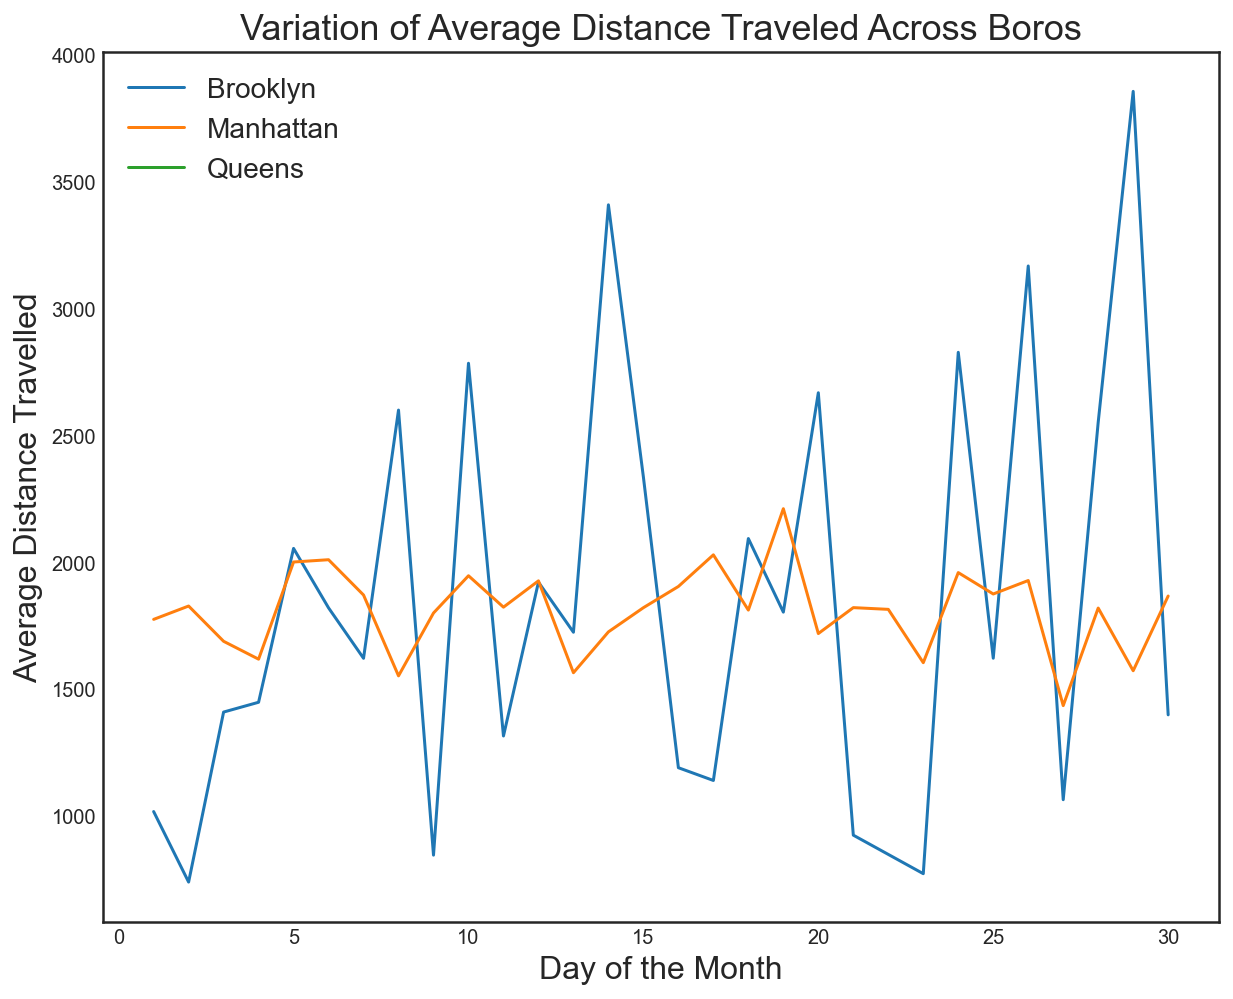

In [70]:
groups= df_avg_dist.groupby('boro_name')
fig, ax = plt.subplots(figsize=(10,8))  # Create a figure and an axes.

for name, group in groups:
    plt.plot(group.day, group.avg_dist_traveled, ms=12, label=name)
#ax.plot(daily_df_cnt['day'],daily_df_cnt['delivery_per_hour'],color='blue')
#plt.axhline(daily_cntai['cnt_per_delivery'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.legend(fontsize=14)
plt.title("Variation of Average Distance Traveled Across Boros",fontsize=18)
plt.xlabel("Day of the Month",fontsize=16)
plt.ylabel("Average Distance Travelled",fontsize=16)
plt.show()

In Brooklyn the carriers need to travel quite long distances, on an average. It will be interesting to visualize it using geographical data below.

In [71]:
geo_data_dropoff = gpd.GeoDataFrame(
    jumpman_data, geometry=gpd.points_from_xy(jumpman_data.dropoff_lon, jumpman_data.dropoff_lat))
#dropoff_geometry = 
#geo_df = gpd.GeoDataFrame(restaurants_boroughs, crs = crs, geometry = pickup_geometry)

In [72]:
dropoff_Brooklyn = gpd.sjoin(map_data,geo_data_dropoff, how="inner", op='contains')
dropoff_Brooklyn.columns;

In [73]:
dropoff_Brooklyn.drop(labels=['geometry','rep'],axis=1,inplace=True);


In [74]:
dropoff_geometry = [Point(xy) for xy in zip(dropoff_Brooklyn['dropoff_lon'], dropoff_Brooklyn['dropoff_lat'])]
geo_dropoff_Brooklyn = gpd.GeoDataFrame(dropoff_Brooklyn, crs = crs, geometry = dropoff_geometry)

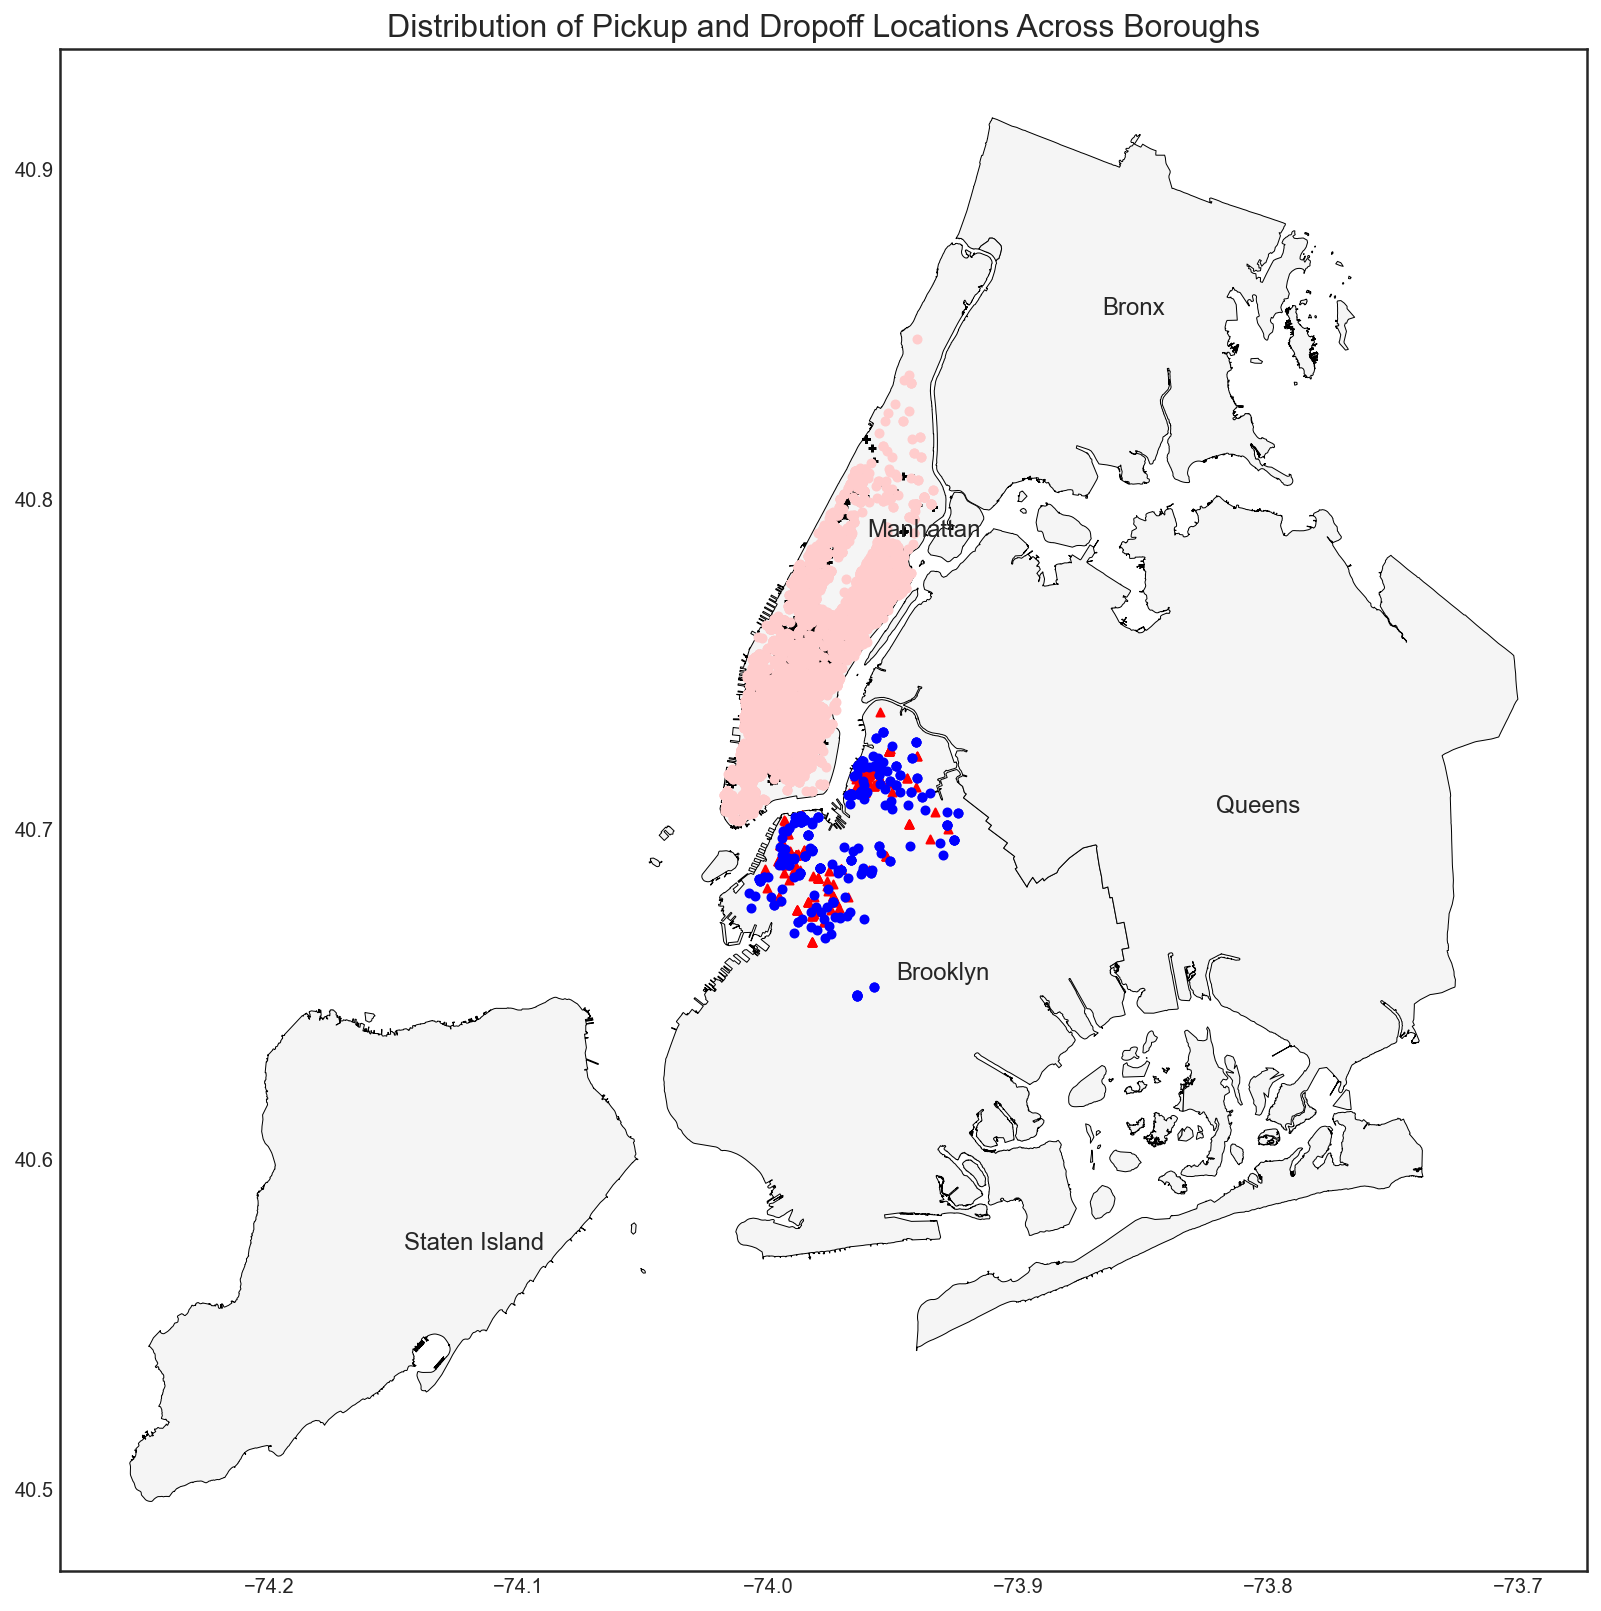

In [75]:
#fig, ax = plt.subplots(figsize = (16,16))
ax = map_data.plot(figsize = (16, 14), color = "whitesmoke", edgecolor = "black", linewidth = 0.5)
texts = []

for x, y, label in zip(map_points.geometry.x, map_points.geometry.y, map_points["boro_name"]):
    texts.append(plt.text(x, y, label, fontsize = 12))

#aT.adjust_text(texts, force_points=0.3, force_text=0.8, expand_points=(1,1), expand_text=(1,1), 
 #              arrowprops=dict(arrowstyle="-", color='grey', lw=0.5))
#map_data.plot(ax=ax, alpha = 0.1, color='grey',edgecolor='green')
geo_df[geo_df['boro_name'] == 'Manhattan'].plot(ax = ax, color = 'black', marker = '+', markersize = 20)

geo_df[geo_df['boro_name'] == 'Brooklyn'].plot(ax = ax, color = 'red', marker = "^", markersize = 16)




geo_dropoff_Brooklyn[geo_dropoff_Brooklyn['boro_name'] == 'Brooklyn'].plot(ax = ax, color = 'blue', marker = "o", markersize = 16)
geo_dropoff_Brooklyn[geo_dropoff_Brooklyn['boro_name'] == 'Manhattan'].plot(ax = ax, color = '#ffcccc', marker = "o", markersize = 16)
plt.title("Distribution of Pickup and Dropoff Locations Across Boroughs",fontsize=16)
plt.show()

In the above map, we can see that Brooklyn has partnerd with pick up places mostly on the edges, hence a pocket of customers/drop-off locations (denoted by deep blue circles) are not having many options close by to order from. This can possibly be the reason for the delays observed in the previous line graph.  In the above map, we can also see couple of outlier drop off points, which are not close to any of the partnered restaurants, causing excess delay. 



Another factor we can consider about is the state of the business in different boroughs at different times of the day. In the following map, we see that Morning time is quite busy in the Manhattan area, but not so in Brooklyn, as evident from the lesser number of  deliveries.

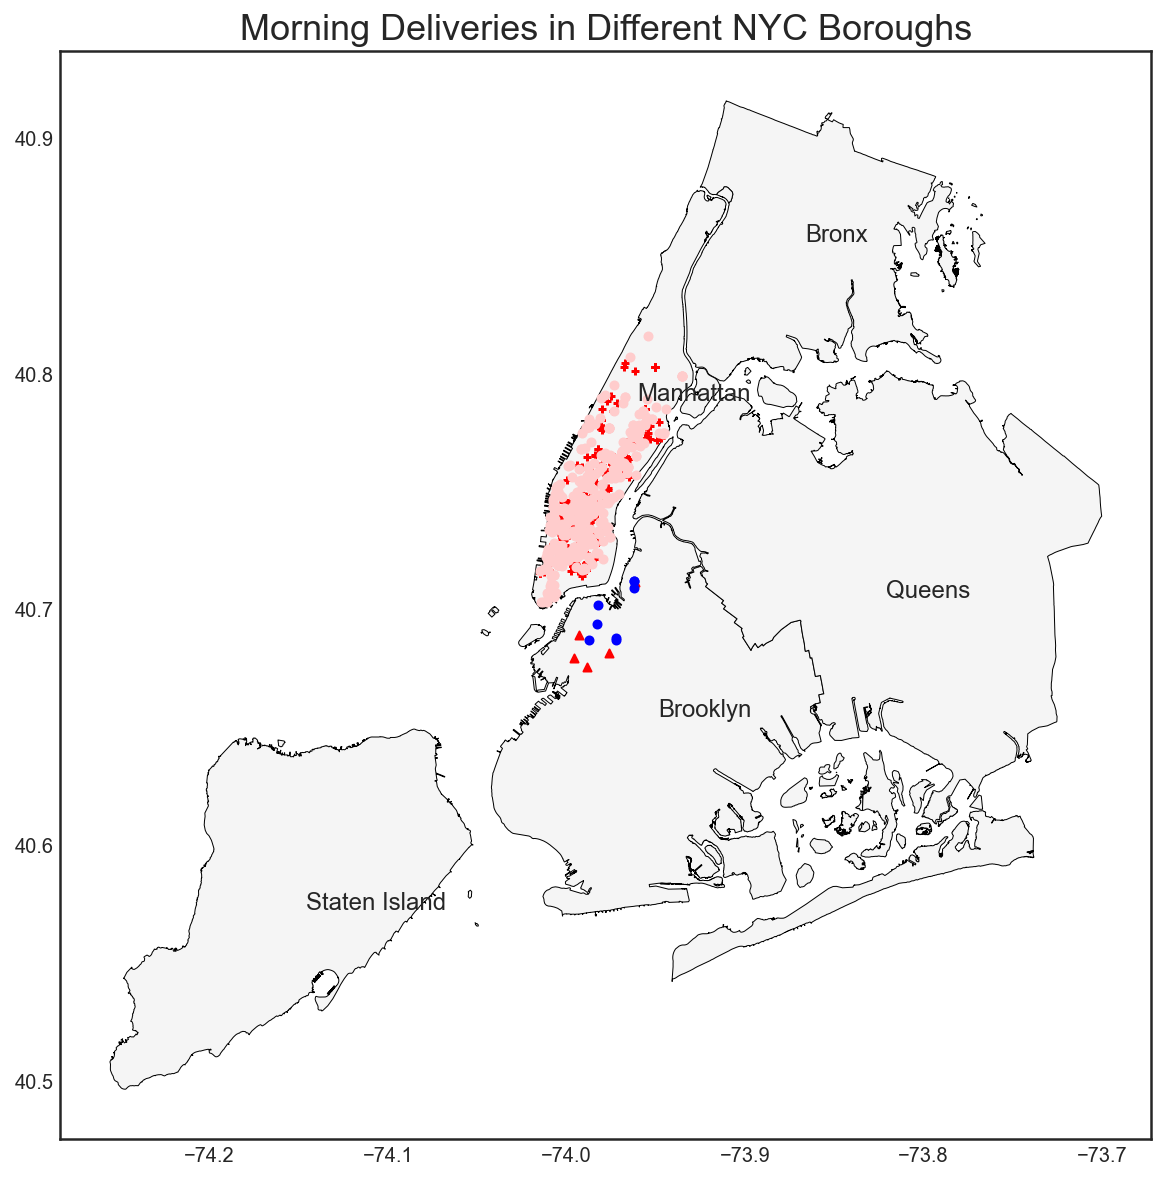

In [76]:
#fig, ax = plt.subplots(figsize = (16,16))
ax = map_data.plot(figsize = (12, 10), color = "whitesmoke", edgecolor = "black", linewidth = 0.5)
texts = []

for x, y, label in zip(map_points.geometry.x, map_points.geometry.y, map_points["boro_name"]):
    texts.append(plt.text(x, y, label, fontsize = 12))

#aT.adjust_text(texts, force_points=0.3, force_text=0.8, expand_points=(1,1), expand_text=(1,1), 
 #              arrowprops=dict(arrowstyle="-", color='grey', lw=0.5))
#map_data.plot(ax=ax, alpha = 0.1, color='grey',edgecolor='green')
geo_df[(geo_df['boro_name'] == 'Manhattan') & (geo_df['Day_Duration'] == 'Morning')].plot(ax = ax, color = 'red', marker = '+', markersize = 20)

geo_df[(geo_df['boro_name'] == 'Brooklyn') & (geo_df['Day_Duration'] == 'Morning')].plot(ax = ax, color = 'red', marker = "^", markersize = 16)




geo_dropoff_Brooklyn[(geo_dropoff_Brooklyn['boro_name'] == 'Brooklyn') & (geo_dropoff_Brooklyn['Day_Duration'] == 'Morning') ].plot(ax = ax, color = 'blue', marker = "o", markersize = 16)
geo_dropoff_Brooklyn[(geo_dropoff_Brooklyn['boro_name'] == 'Manhattan') & (geo_dropoff_Brooklyn['Day_Duration'] == 'Morning')].plot(ax = ax, color = '#ffcccc', marker = "o", markersize = 16)
plt.title('Morning Deliveries in Different NYC Boroughs',fontsize=18)
plt.show()


To summarize, in this section we looked at the KPI's described in the first section across different boroughs. Our findings include;

* First, average Number of Daily Deliveries is Increasing Consistently for Manhattan, but the numbers are quite steady in Brooklyn.

* Second, for Manhattan, hourly deliveries have a very promising trend, which is a good news for the management. But some work needs to be done to get customers more engaged in Brooklyn.

* Third, the order duration and distance travelled has shown some wild swings in Brooklyn, but it is quite consistent in Manhattan. The swings in Brooklyn could be due to the fact that most of the pickup locations are located on the edges of the Borough, and few drop off locations are acting as outliers as shown in the maps above. 




### Handle Missing Values

Earlier we saw that the column, `item_category_name` has almost 20 percent missing values. Before we decide how to handle these missing values, it will be interesting to observe raw data. Maybe, it is likely that items purchased from some pick up places miss the item category quite frequently.

In [77]:
jumpman_data.drop(columns='geometry',inplace=True)

In [78]:
item_category_null = jumpman_data[jumpman_data['item_category_name'].isnull()]
missing_category = pysqldf(''' SELECT pickup_place, COUNT(*) AS missing_item_category, \
                                ROUND(((COUNT(*) * 1.)/1230)*100,2)  AS missing_pct \
                                FROM item_category_null \
                               GROUP BY pickup_place 
                               ORDER BY 2 DESC
                               LIMIT 10 ;''')
missing_category

,pickup_place,missing_item_category,missing_pct
0,Duane Reade,64,5.20
1,Chipotle Mexican Grill $1.99 Delivery,56,4.55
2,Philippe Chow,24,1.95
3,Starbucks,23,1.87
4,Sushi Seki (archived),19,1.54
5,McDonald's,19,1.54
6,sweetgreen,15,1.22
7,Whole Foods Market,15,1.22
8,Serafina Meatpacking,15,1.22
9,Sant Ambroeus,15,1.22


Above data tells us that the `Duane Reade` and `Chipotle` are missing the item category frequently. As we know `Duane Reade` is a part of Walgreen store, it is possible that some of the items purchased there cannot be classified into any suitable categories.  

Next, we will investigate the variable,`how_long_it_took_to_order`. This is a very crucial metric to measure the performance of food delivery app. But we saw earlier that it has close to 50 percent missing values. We will look at some pattern in this missing data, is it in a particular borough, or for pickup place, etc. 

In [79]:
order_time_null = jumpman_data[jumpman_data['how_long_it_took_to_order'].isnull()]
cnt=order_time_null.shape[0]

# we'll look at some pick up places which has the highest missing data

missing_order_time = pysqldf(''' SELECT pickup_place, COUNT(*) AS missing_item_category, \
                                ROUND(((COUNT(*) * 1.)/2945)*100,2)  AS missing_pct \
                                FROM order_time_null \
                               GROUP BY pickup_place 
                               ORDER BY 2 DESC
                               LIMIT 10 ;''')
missing_order_time

,pickup_place,missing_item_category,missing_pct
0,Shake Shack,311,10.56
1,Momofuku Milk Bar,186,6.32
2,Blue Ribbon Fried Chicken,133,4.52
3,Whole Foods Market,119,4.04
4,Mighty Quinn's BBQ,90,3.06
5,Chipotle Mexican Grill $1.99 Delivery,80,2.72
6,Momofuku Noodle Bar,74,2.51
7,Trader Joe's,68,2.31
8,Hu Kitchen,68,2.31
9,Duane Reade,64,2.17


It is seen that the place Shake Shack which is a burger place has all values empty for the column, `how_long_it_took_to_order`. This is a missing data issue, and it affects the analysis in the sense, that we can't ascertain the promptness of this place, and whether the food delivery app should continue their partnership with this restaurant. Similarly, we can investigate other pickup places too.

## Summary
To summarize the analysis; we investigated the market data for the Jumpman23 delivery platform in New York City for October 2014. Our findings include;

* First we looked at the KPI's which are of primary interest to the business;

  -  **Average Daily Deliveries** - we saw that in Manhattan the number of average daily deliveries is showing a promising trend week over week. But in Brooklyn, it is not so significant, but it is consistent.
  - **Average Hourly Deliveries** - In Manhattan, this KPI is quite consistent, in particular has an upward trend over the weekends. This signifies that the app is reaching wider population base.
  - **Average Order Duration** - On a given day, the average order duration is quite consistent and reasonable in Manhattan. But in Brooklyn it has shown swings in the trend. This can be attributed to the location of few outlier drop-off locations, as shown in the map. Moreover, few drop of locations are missing pickup places in their vicinity, hence might need to order from farther locations, causing delay in order delivery.
  
* Second, we investigated the Customer preference at different times of the day, and found that during night time, the number of deliveries is quite high. This makes sense for food apps, because people might be busy working late or having late night appetite. Moreover the customers have different food preferences, depending on the times of the day.

* Third, we also identified few Data Integrity issues in the dataset, in particular several variables have significant amount of missing data. For example, we found that the variable `how_long_it_took_to_order` has close to 50 percent missing data. This is a very crucial metric for success of food apps, and it is important for this variable to have filled data. In addition, few burger and dairy places seem to be suffering from this issue the most. 


### Recommendations
* We are seeing an increase in weekend hourly deliveries, that's a good sign, maybe we can send more push notifications/promotions over the weekend to attract more engagement (limited time conversion focused campaigns).

* Another metric which can be tracked is; app latency or app crashes. We'll need more information to track this metric. It is related to the information on how long it took to order. Comparing this trend on weekdays vs. weekends might be useful information.

* Customer retention; like how many additional users placed orders, and what fraction of original customers made orders in last week also.

* Next, if we know the time of the day when we have more frequent logins, that is a good opportunity to push notifications, incentives etc.

* Another KPI we can compare across Boroughs, the change in number of deliveries on a daily basis, it can tell is how fast is the business expanding. 

* Earlier we saw that during morning hours, Manhattan sees quite healthy number of deliveries, as compared to Brooklyn. This is primarily due to the fact that people travel to Manhattan for work. One strategy which can be used in Manhattan is, partnering with the workplaces to give promotions/discounts if they make large number of orders. Using this strategy, the food delivery system can leverage the morning traffic to their advantage.

* Next, it is needed to partner with more restaurants in Brooklyn as the higher delivery time on few days suggest. A smart strategy will be to offer some promotions to new partner restaurants to earn their trust and loyalty. Moreover, giving more options to customers is always a good option. his can help in customer retention too. For example, if a customer often orders Thai food from restaurant A, then h/she will be delighted to see other restaurants also on the app offering Thai food.